In [1]:
# librerias que utilizaras
import numpy as np
# por si no te lee las tools o functions creadas
import sys
sys.path.append("/home/serch/pdbmani/Serch/math_tricks/")
sys.path.append("/home/serch/pdbmani/Serch/")
import math_vect_tools as mymath
# herramientas para leer pdbs
import read_pdb_tools as rpt
# funciones de click generadas en pandas
import funciones_CLICK as fc
# cuenta tiempo de ejecucion
# networks
import networkx as nx

import os
os.chdir('/home/serch/pdbmani/Serch')

from collections import Counter # obtener conteo de enlaces
import ast # para pasar de str a tupla o lista

# Funcion de generacion de red de contacto.. omitiendo residuos que no nos interesan.

In [2]:
def gen_networks_tray(path,file, use_center_mass=False, min_distance_edge = 10, keep_edge_proba=0.7):
    
    path=path
    file=file
    pathfile = path+file
    
    # se define la estructura
    trj1 = rpt.Trajectory(pathfile)

    # se lee el pdb y se agrega al objeto
    trj1.ReadTraj("%s" % pathfile)
    # concatenado de frames
    trj11 = trj1.frames
    
    print('numero de frames:', len(trj11))
    
    if use_center_mass:
        for pdbstruct in trj11:
            pdbstruct.set_center_mass()
            
    def get_df_distancias(ref):
        """Funcion para obtener los enlaces de distancias de cada residuo
        Dudas en codigo pueden revisar fc.distancia_entre_atomos en ese se basa
        esta funcion, la diferencia es que se crea con el objeto residuo"""
        # se generan listas con coordenadas y numero de atomo
        #     enlaces = [ [res1.resi, res2.resi] for res1 in ref[1:-1] for res2 in ref[1:-1] 
        #                if res2.resi >= res1.resi if mymath.distance(res2.GetAtom('CA').coord, res1.GetAtom('CA').coord) < 10
        #               ]

        enlaces = []
        for res1 in ref:
            for res2 in ref:
                if res1.resi in [1,178, 201,378] or res2.resi in [1, 178, 201,378]: # se hizo a  mano el quitar los atomos que no nos interesn
                    continue
                else:
                    if res2.resi >= res1.resi and res2.resi != res1.resi:
                        dist = mymath.distance(res2.GetAtom('CA').coord, res1.GetAtom('CA').coord)
                        if  dist < min_distance_edge:
                            enlaces.append([res1.resi, res2.resi])

        # se genera la matriz de adyacencias para la red
        return enlaces

    pdbs = [pdb.GetResChain() for pdb in trj11]

    enlaces = [get_df_distancias(residues) for residues in pdbs]
    

    a = Counter([str(j) for i in enlaces for j in i]).most_common()

   
    red_promedio = nx.Graph([ast.literal_eval(i[0]) for i in a if (i[1] / len(enlaces)) > keep_edge_proba], name=file.split('.')[0])

    print(nx.info(red_promedio))

    print(trj11[0].PrintPdbInfo())
    
    return red_promedio

In [6]:
%%time
red_dimer_con_cofact = gen_networks_tray('/home/serch/pdbmani/Serch/pdbs_align_reference/','dimer_con_cofact_clean2.pdb')
red_tetra_con_cofact = gen_networks_tray('/home/serch/pdbmani/Serch/pdbs_align_reference/','tetra_con_cofact_clean2_click.pdb')
red_dimer_sin_cofact = gen_networks_tray('/home/serch/pdbmani/Serch/pdbs_align_reference/','dimer_sin_cofact_clean2.pdb')
red_tetra_sin_cofact = gen_networks_tray('/home/serch/pdbmani/Serch/pdbs_align_reference/','tetra_sin_cofact_clean.pdb')

numero de frames: 516
Name: dimer_con_cofact_clean2
Type: Graph
Number of nodes: 352
Number of edges: 2843
Average degree:  16.1534
Number of residues and frame: 352    1
Number of chains:             1  dict_keys(['A'])
None
numero de frames: 435
Name: tetra_con_cofact_clean2_click
Type: Graph
Number of nodes: 352
Number of edges: 2829
Average degree:  16.0739
Number of residues and frame: 352    1
Number of chains:             1  dict_keys(['A'])
None
numero de frames: 501
Name: dimer_sin_cofact_clean2
Type: Graph
Number of nodes: 352
Number of edges: 2844
Average degree:  16.1591
Number of residues and frame: 352    1
Number of chains:             1  dict_keys(['A'])
None
CPU times: user 10min 33s, sys: 1.64 s, total: 10min 34s
Wall time: 10min 37s


In [3]:
red_tetra_sin_cofact = gen_networks_tray('/home/serch/pdbmani/Serch/pdbs_align_reference/','tetra_sin_cofact_clean.pdb')

numero de frames: 501
Name: tetra_sin_cofact_clean
Type: Graph
Number of nodes: 352
Number of edges: 2777
Average degree:  15.7784
Number of residues and frame: 352    1
Number of chains:             1  dict_keys(['A'])
None


In [4]:
nx.write_gexf(red_dimer_con_cofact, '/home/serch/pdbmani/Serch/networks_scripts/gexf/red_dimer_con_cofact.gexf')
nx.write_gexf(red_tetra_con_cofact, '/home/serch/pdbmani/Serch/networks_scripts/gexf/red_tetra_con_cofact.gexf')
nx.write_gexf(red_dimer_sin_cofact, '/home/serch/pdbmani/Serch/networks_scripts/gexf/red_dimer_sin_cofact.gexf')
nx.write_gexf(red_tetra_sin_cofact, '/home/serch/pdbmani/Serch/networks_scripts/gexf/red_tetra_sin_cofact.gexf')

# Hasta aqui se generaron las redes de contacto de los tres experimentos falta uno!!!

------------

# Aca se analizan las comunidades o en gephi

In [10]:
red_dimer_con_cofact = nx.read_gexf('/home/serch/pdbmani/Serch/networks_scripts/gexf/red_dimer_con_cofact.gexf')
red_tetra_con_cofact = nx.read_gexf('/home/serch/pdbmani/Serch/networks_scripts/gexf/red_tetra_con_cofact.gexf')
red_dimer_sin_cofact = nx.read_gexf('/home/serch/pdbmani/Serch/networks_scripts/gexf/red_dimer_sin_cofact.gexf')
red_tetra_sin_cofact = nx.read_gexf('/home/serch/pdbmani/Serch/networks_scripts/gexf/red_tetra_sin_cofact.gexf')

## Dimer con cofact Red

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
import seaborn as sns

### Metricas globales

In [29]:
print(nx.info(red_dimer_con_cofact))

Name: dimer_con_cofact_clean2
Type: Graph
Number of nodes: 352
Number of edges: 2843
Average degree:  16.1534


In [30]:
# densidad, porcentaje de enlaces de todos los posibles que puede haber. #Densidad baja#
nx.density(red_dimer_con_cofact)

0.04602110852110852

In [45]:
# clustering promedio
nx.average_clustering(red_dimer_con_cofact)

0.5440602613327103

In [46]:
# promedio de camnino mas corto
nx.average_shortest_path_length(red_dimer_con_cofact)

4.066741129241129

In [60]:
# porcentaje de triangulos existentes de todos los posibles tringulos posibles
nx.transitivity(red_dimer_con_cofact)

0.5015994881637876

no es una red aleatoria, no cumple todas las propiedades de ella, como clustering y promedio de camino mas corto

In [61]:
# el camino mas largo entre todos los caminos posibles sobre cada par de nodos
nx.diameter(red_dimer_con_cofact)

10

In [63]:
# el camino mas corto sobre todos los caminos mas largos de los caminos posibles de cada par de nodos
nx.radius(red_dimer_con_cofact)

5

In [62]:
# excentricidad es la maxima distancia de un nodo a todos los demas en la red
# nodos con una excentricidad igual al radio

nx.center(red_dimer_con_cofact)

['144', '142', '141', '143', '342', '343']

In [20]:
df = pd.DataFrame([i for i in red_dimer_con_cofact.degree], columns=['node_id','degree'])
df.head()

,node_id,degree
0,2,8
1,3,11
2,4,13
3,5,12
4,6,13


In [56]:
# grado promedio
df.mean()

node_id          inf
degree     16.153409
dtype: float64

Text(0.5,1,'Boxplot del grado, no se observan outliers')

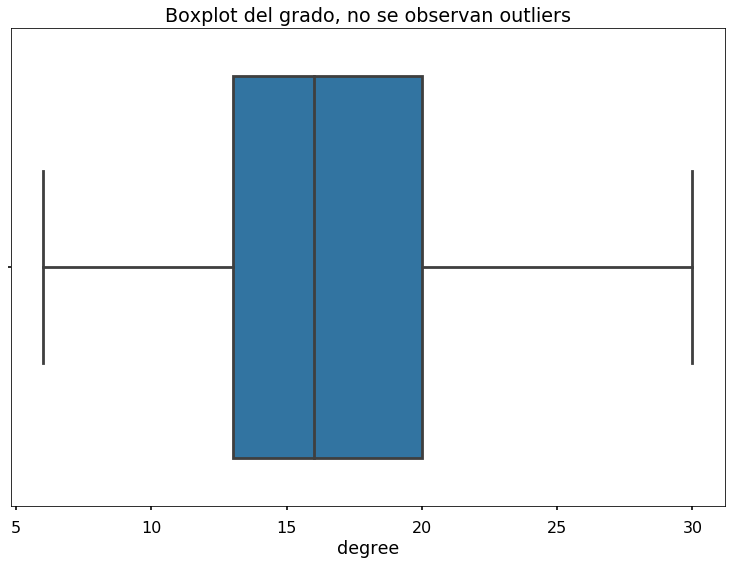

In [70]:
sns.boxplot(data=df,x='degree')
plt.title('Boxplot del grado, no se observan outliers')

Text(0.5,0,'grado')

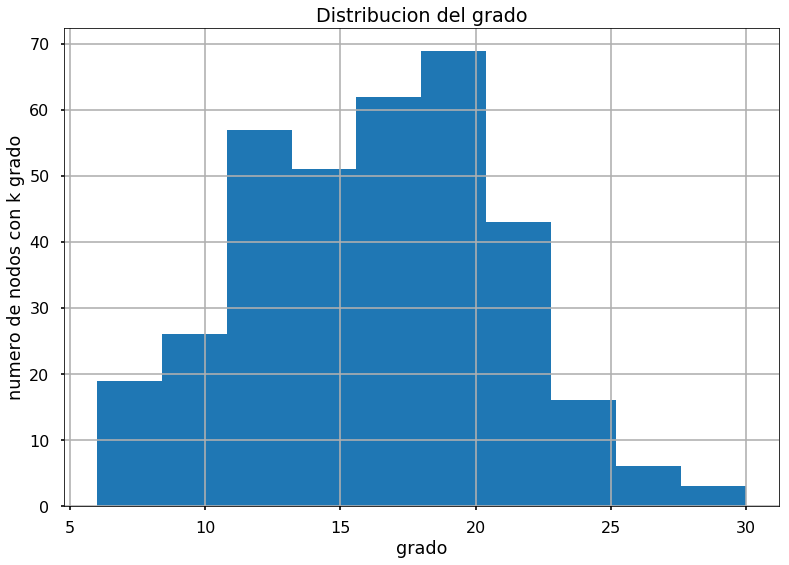

In [74]:
df.degree.hist()
plt.title('Distribucion del grado')
plt.ylabel('numero de nodos con k grado')
plt.xlabel('grado')

La distribucion del grado parece una normal.

Text(16.1534,0.081,'grado promedio')

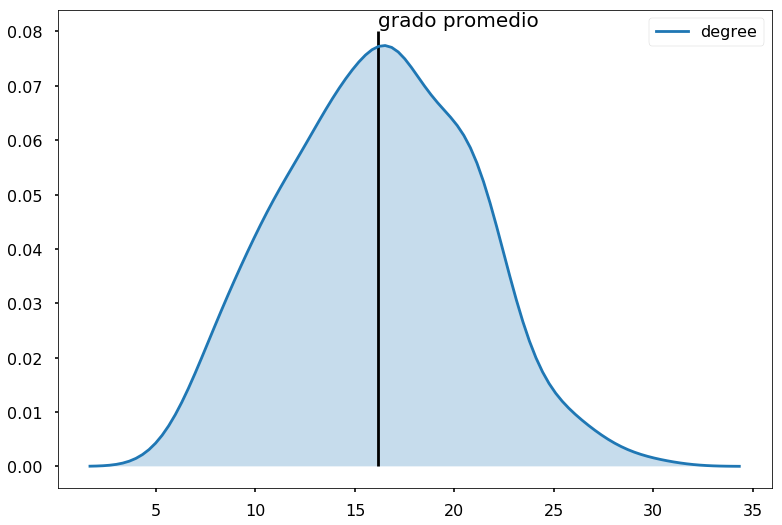

In [81]:
sns.kdeplot(df.degree, shade=True)
plt.vlines(df.degree.mean(),0,0.08)
plt.text(df.degree.mean(),0.081,'grado promedio',fontsize=20)

In [102]:
# No jala! con eigenvector ni con hits
def measuring(red):
    dgr = nx.degree_centrality(red)
    clo = nx.closeness_centrality(red)
    har = nx.harmonic_centrality(red)
    eig = nx.eigenvector_centrality_numpy(red)
    bet = nx.betweenness_centrality(red)
    pgr = nx.pagerank(red)
    hits = nx.hits_numpy(red)
    
    centralities = pd.concat(
    [pd.Series(c) for c in (hits[1],eig,pgr,har,clo,hits[0],dgr,bet)],
    axis=1)
    centralities.columns = ["Authorities","Eigenvector", "PageRank",
                           "Harmonic_Closeness", "Closeness","Hubs",
                           "Degree", "Betweenness"]
    centralities["Harmonic_Closeness"] /= centralities.shape[0]
    
    return centralities

In [107]:
measuring(red_dimer_con_cofact).sort_values('Betweenness', ascending=False).head()

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
340,0.004512,0.064825,0.003769,0.384848,0.330198,0.004512,0.068376,0.072757
140,0.004171,0.059920,0.003370,0.378409,0.326816,0.004171,0.059829,0.063190
106,0.002000,0.028729,0.002964,0.342431,0.290804,0.002000,0.048433,0.048209
306,0.002934,0.042159,0.002790,0.343351,0.293724,0.002934,0.045584,0.044391
143,0.003713,0.053342,0.002724,0.365909,0.322018,0.003713,0.048433,0.042443


In [277]:
measuring(red_dimer_con_cofact).sort_values('Degree', ascending=False).head()

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
301,0.012895,0.185268,0.004391,0.380019,0.303109,0.012895,0.085470,0.036891
237,0.011434,0.164276,0.004184,0.359307,0.285831,0.011434,0.079772,0.015509
101,0.006744,0.096895,0.004135,0.373106,0.296453,0.006744,0.079772,0.029338
37,0.005992,0.086094,0.004063,0.354742,0.280128,0.005992,0.076923,0.013103
47,0.005884,0.084535,0.003906,0.344366,0.266313,0.005884,0.074074,0.011946


In [109]:
pd.read_csv('networks_scripts/data_csv/dimer_con_cofact.csv').sort_values('betweenesscentrality', ascending=False).head()

,Id,Label,timeset,degree,weighted degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,modularity_class,clustering,triangles
174,340,340,NaN,24,24,6,0.330198,0.385945,0.072757,4,0.373188,103
160,140,140,NaN,21,21,6,0.326816,0.379487,0.063190,2,0.376190,79
151,106,106,NaN,17,17,7,0.290804,0.343407,0.048209,0,0.470588,64
333,306,306,NaN,16,16,7,0.293724,0.344329,0.044391,4,0.516667,62
164,143,143,NaN,17,17,5,0.322018,0.366952,0.042443,4,0.470588,64


In [119]:
def corr_centralities(df_measuring, m=10):
    c_df = df_measuring.corr()
    ll_triangle = np.tri(c_df.shape[0], k=-1)
    c_df *= ll_triangle
    c_series = c_df.stack().sort_values().tail(m)
    return c_series

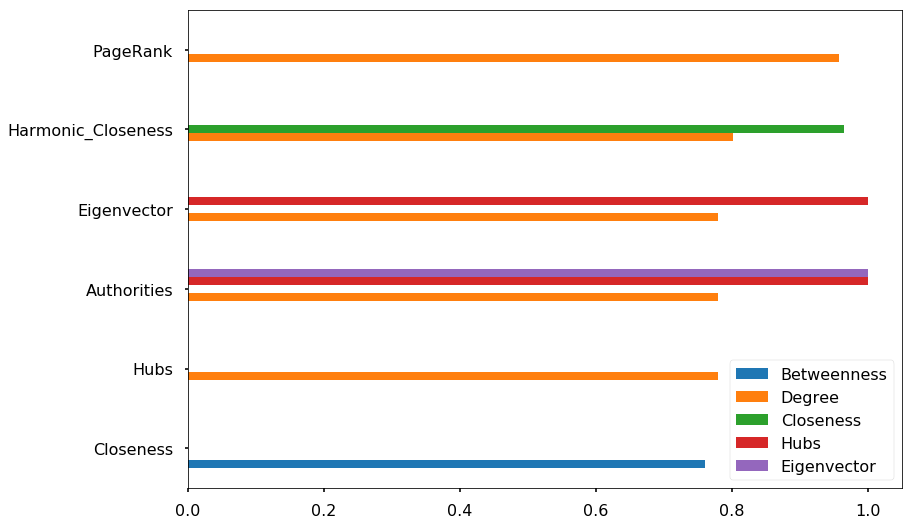

In [128]:
corr_centralities(measuring(red_dimer_con_cofact), m=10).unstack(0).plot.barh()

In [132]:
def plot_centralities(df_measuring,col1,col2):
    X=col1
    Y=col2
    limits = pd.concat([df_measuring[[X,Y]].min(),df_measuring[[X,Y]].max()], axis=1).values
    df_measuring.plot(kind='scatter', x=X, y=Y, xlim=limits[0],ylim=limits[1],s=75,logy=False,alpha=0.6)

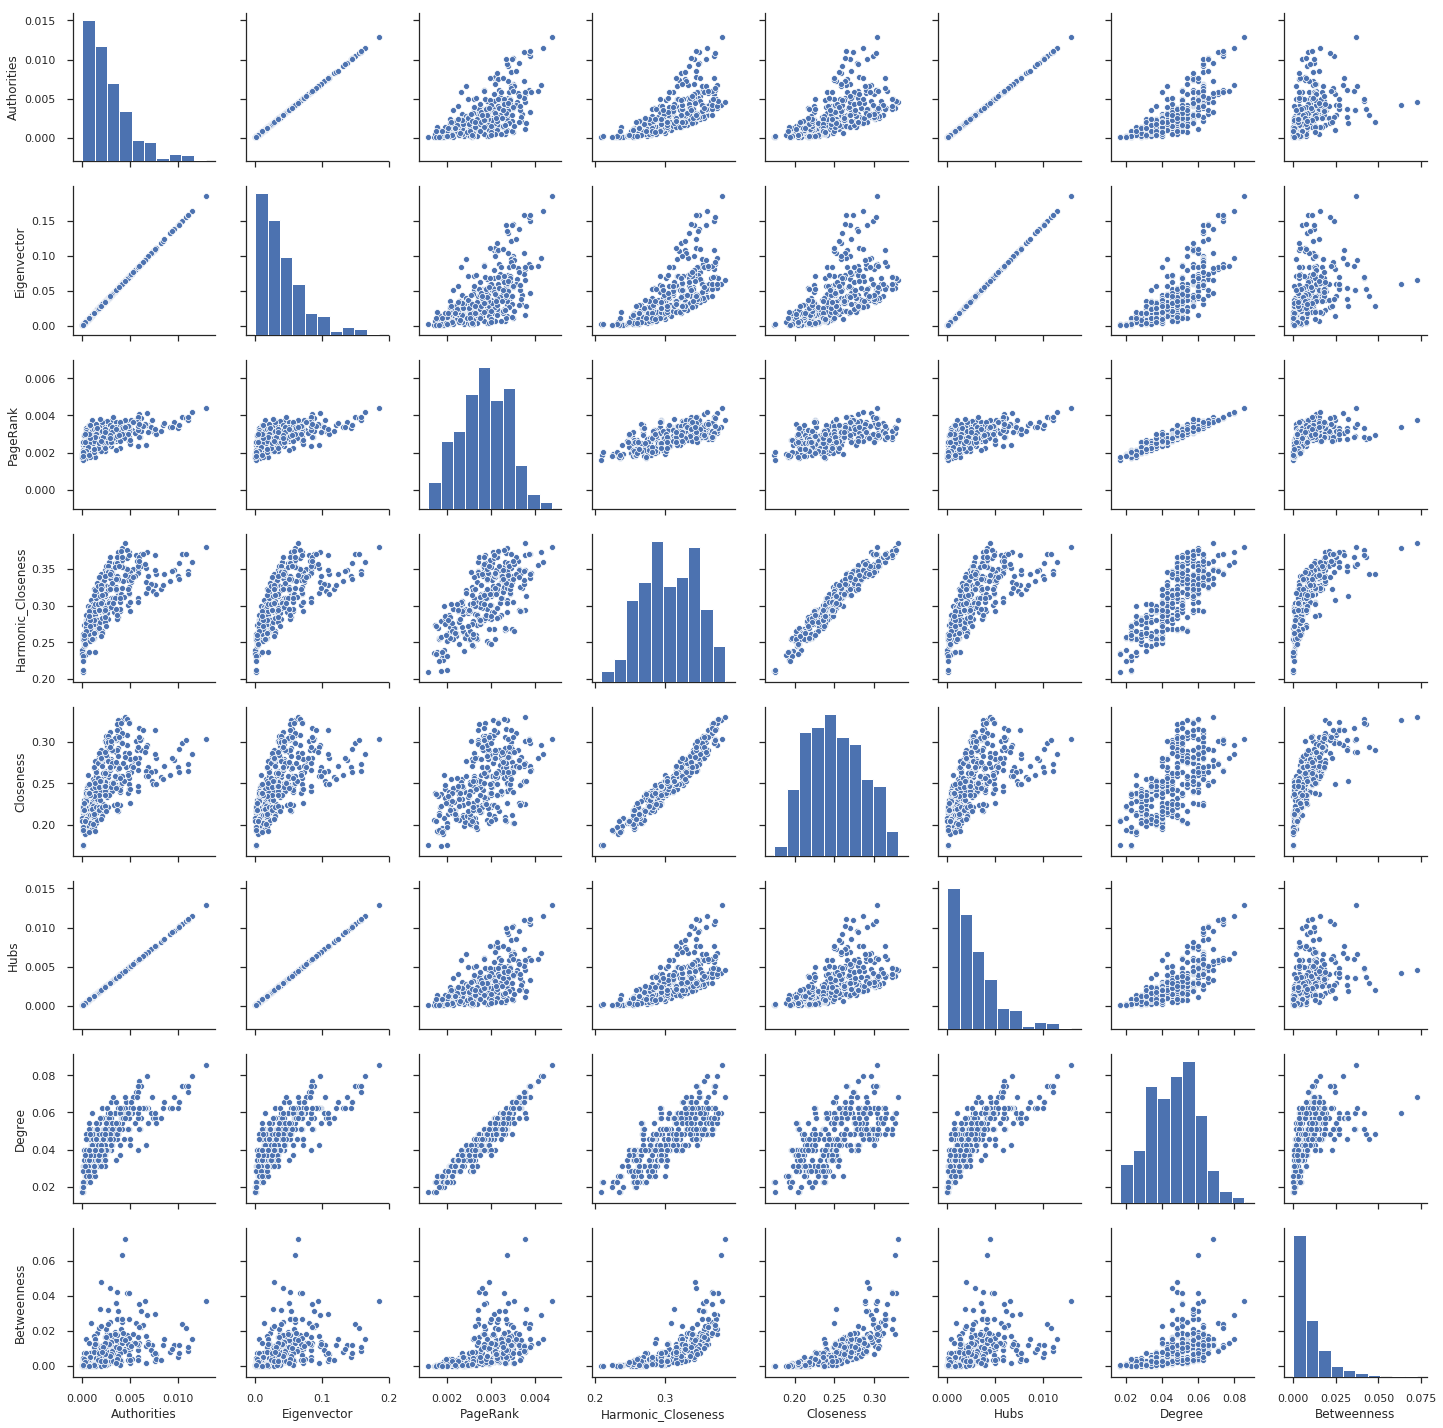

In [136]:
sns.set(style="ticks")
sns.pairplot(df_measuring)

In [137]:
# for i in df_measuring.columns:
#     for j in df_measuring.columns:
#         plot_centralities(df_measuring,i,j)

## Analsis de comunidades

In [138]:
import community

In [273]:
part = community.best_partition(red_dimer_con_cofact)

In [274]:
community.modularity(part,red_dimer_con_cofact)

0.5917213527396774

In [275]:
induced = community.induced_graph(part, red_dimer_con_cofact)

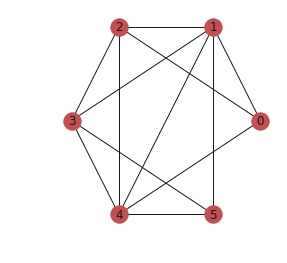

In [276]:
plt.figure(figsize=(3,3))
nx.draw_circular(induced,with_labels=True)

In [190]:
top_bet = measuring(red_dimer_con_cofact).sort_values('Betweenness', ascending=False).head(20).index.values

In [191]:
top_bet

array(['340', '140', '106', '306', '143', '343', '342', '304', '301',
       '104', '145', '344', '359', '139', '346', '146', '329', '101',
       '141', '144'], dtype=object)

In [192]:
# a que comunidad pertenecen los de mayor betweness
for i in top_bet:
    print(i,part[i])

340 4
140 1
106 1
306 4
143 1
343 1
342 4
304 5
301 3
104 0
145 0
344 1
359 5
139 1
346 5
146 0
329 1
101 2
141 1
144 1


Text(0,0.5,'comunidad')

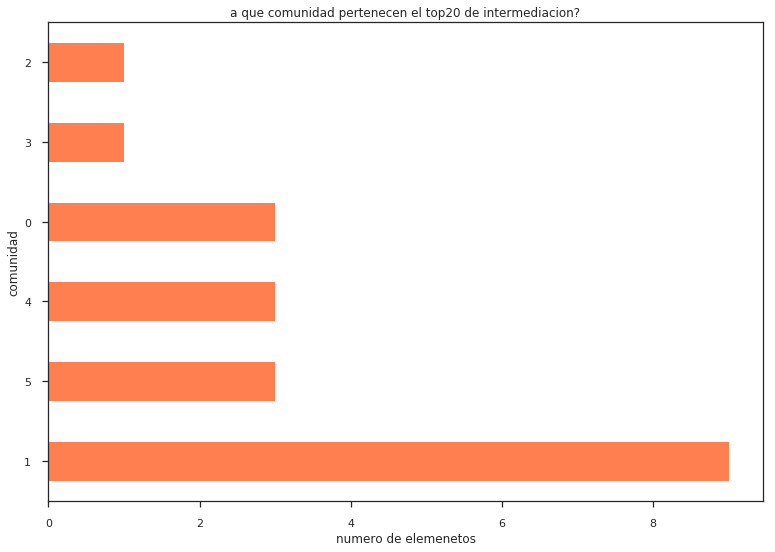

In [210]:
pd.DataFrame([(i,part[i]) for i in top_bet ]).set_index(0)[1].value_counts().plot.barh(
    title='a que comunidad pertenecen el top20 de intermediacion?', color='coral')
plt.xlabel('numero de elemenetos')
plt.ylabel('comunidad')

In [189]:
df_measuring.describe()

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.002841,0.040815,0.002841,0.305581,0.250578,0.002841,0.046021,0.008762
std,0.002389,0.034327,0.000550,0.038214,0.034391,0.002389,0.013272,0.010098
min,0.000068,0.000984,0.001576,0.208950,0.174367,0.000068,0.017094,0.000000
25%,0.001054,0.015141,0.002482,0.276629,0.222222,0.001054,0.037037,0.001747
50%,0.002273,0.032655,0.002853,0.303937,0.248672,0.002273,0.045584,0.004940
75%,0.003865,0.055535,0.003277,0.338327,0.277690,0.003865,0.056980,0.012534
max,0.012895,0.185268,0.004391,0.384848,0.330198,0.012895,0.085470,0.072757


In [184]:
df_measuring.loc[top_bet]

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
340,0.004512,0.064825,0.003769,0.384848,0.330198,0.004512,0.068376,0.072757
140,0.004171,0.059920,0.003370,0.378409,0.326816,0.004171,0.059829,0.063190
106,0.002000,0.028729,0.002964,0.342431,0.290804,0.002000,0.048433,0.048209
306,0.002934,0.042159,0.002790,0.343351,0.293724,0.002934,0.045584,0.044391
143,0.003713,0.053342,0.002724,0.365909,0.322018,0.003713,0.048433,0.042443
343,0.004891,0.070273,0.002859,0.368324,0.322314,0.004891,0.051282,0.041748
342,0.004748,0.068211,0.003298,0.375521,0.327425,0.004748,0.059829,0.041465
304,0.006586,0.094622,0.003525,0.357170,0.288177,0.006586,0.062678,0.037162
301,0.012895,0.185268,0.004391,0.380019,0.303109,0.012895,0.085470,0.036891
104,0.003607,0.051825,0.003382,0.355269,0.288177,0.003607,0.059829,0.036229


Text(0,0.5,'Comunidad')

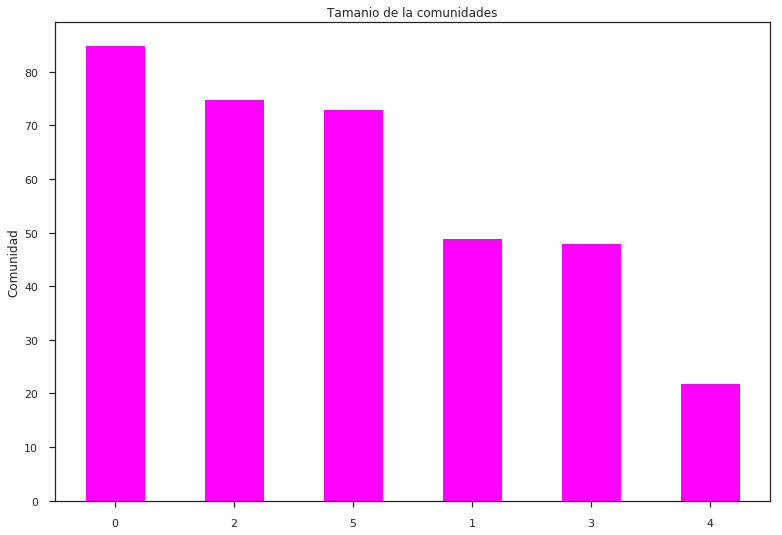

In [211]:
pd.Series(part).value_counts().plot.bar(rot=0, title='Tamanio de la comunidades', color='magenta')
plt.ylabel('Numero de nodos')
plt.ylabel('Comunidad')

------

## Dimer sin cofact Red

### Metricas globales

In [212]:
print(nx.info(red_dimer_sin_cofact))

Name: dimer_sin_cofact_clean2
Type: Graph
Number of nodes: 352
Number of edges: 2844
Average degree:  16.1591


In [213]:
# densidad, porcentaje de enlaces de todos los posibles que puede haber. #Densidad baja#
nx.density(red_dimer_sin_cofact)

0.04603729603729604

In [214]:
# clustering promedio
nx.average_clustering(red_dimer_sin_cofact)

0.5458223672057246

In [215]:
# promedio de camnino mas corto
nx.average_shortest_path_length(red_dimer_sin_cofact)

4.068359880859881

In [216]:
# porcentaje de triangulos existentes de todos los posibles tringulos posibles
nx.transitivity(red_dimer_sin_cofact)

0.5008394075270417

no es una red aleatoria, no cumple todas las propiedades de ella, como clustering y promedio de camino mas corto

In [217]:
# el camino mas largo entre todos los caminos posibles sobre cada par de nodos
nx.diameter(red_dimer_sin_cofact)

9

In [218]:
# el camino mas corto sobre todos los caminos mas largos de los caminos posibles de cada par de nodos
nx.radius(red_dimer_sin_cofact)

5

In [219]:
# excentricidad es la maxima distancia de un nodo a todos los demas en la red
# nodos con una excentricidad igual al radio

nx.center(red_dimer_sin_cofact)

['144', '142', '143', '340', '341', '342', '343', '344']

In [220]:
df = pd.DataFrame([i for i in red_dimer_sin_cofact.degree], columns=['node_id','degree'])
df.head()

,node_id,degree
0,2,7
1,3,8
2,4,11
3,5,12
4,175,14


In [221]:
# grado promedio
df.mean()

node_id          inf
degree     16.159091
dtype: float64

Text(0.5,1,'Boxplot del grado, no se observan outliers')

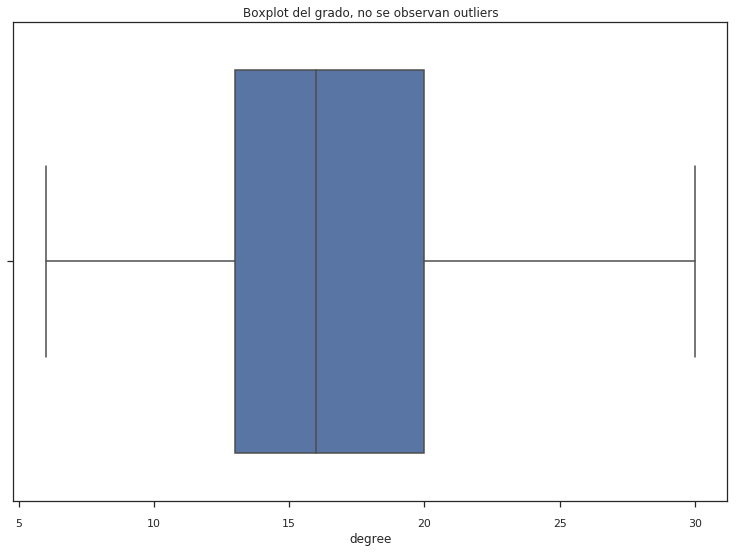

In [222]:
sns.boxplot(data=df,x='degree')
plt.title('Boxplot del grado, no se observan outliers')

Text(0.5,0,'grado')

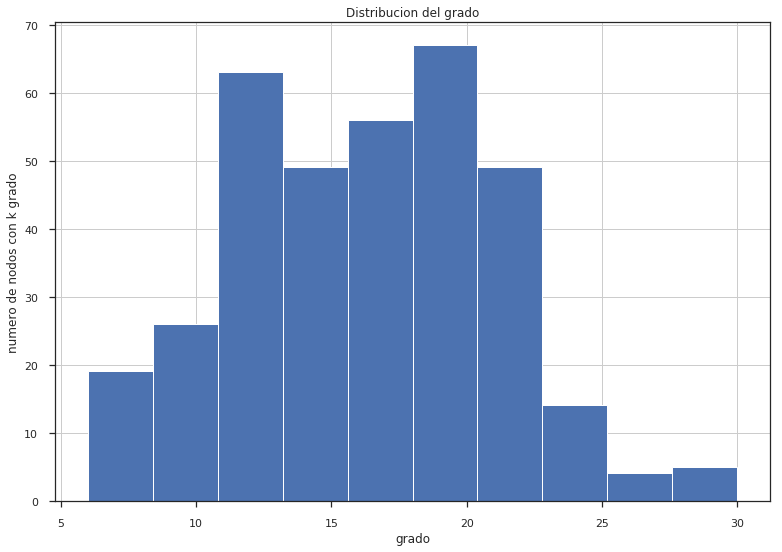

In [223]:
df.degree.hist()
plt.title('Distribucion del grado')
plt.ylabel('numero de nodos con k grado')
plt.xlabel('grado')

La distribucion del grado parece una normal.

Text(16.1591,0.081,'grado promedio')

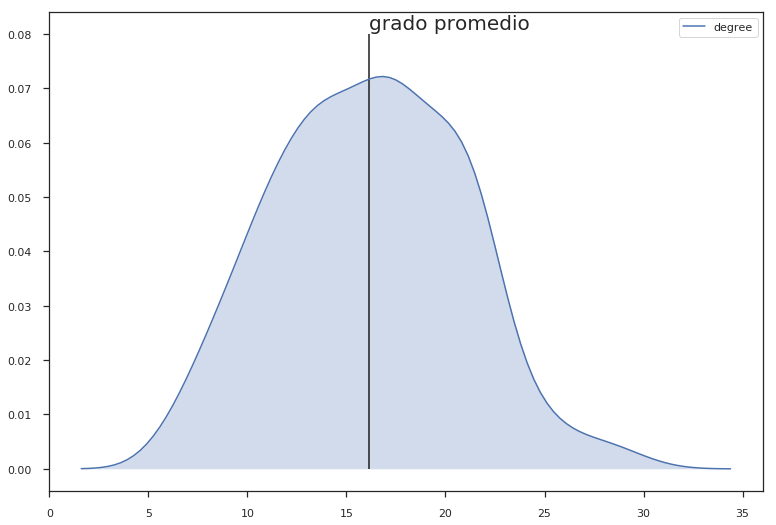

In [224]:
sns.kdeplot(df.degree, shade=True)
plt.vlines(df.degree.mean(),0,0.08)
plt.text(df.degree.mean(),0.081,'grado promedio',fontsize=20)

In [225]:
measuring(red_dimer_sin_cofact).sort_values('Betweenness', ascending=False).head()

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
340,0.004824,0.071711,0.003624,0.384848,0.333017,0.004824,0.065527,0.071437
140,0.004446,0.066097,0.003484,0.381297,0.328652,0.004446,0.062678,0.059427
306,0.002495,0.037096,0.002993,0.346117,0.296703,0.002495,0.048433,0.050703
342,0.004844,0.072006,0.003290,0.378125,0.329887,0.004844,0.059829,0.042696
143,0.004596,0.068316,0.002844,0.374148,0.329577,0.004596,0.051282,0.042002


In [226]:
pd.read_csv('networks_scripts/data_csv/dimer_sin_cofact.csv').sort_values('betweenesscentrality', ascending=False).head()

,Id,Label,timeset,degree,weighted degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,modularity_class,clustering,triangles
171,340,340,NaN,23,23,5,0.333017,0.385945,0.071437,5,0.379447,96
158,140,140,NaN,22,22,6,0.328652,0.382384,0.059427,2,0.389610,90
328,306,306,NaN,17,17,6,0.296703,0.347104,0.050703,5,0.463235,63
181,342,342,NaN,21,21,5,0.329887,0.379202,0.042696,5,0.428571,90
162,143,143,NaN,18,18,5,0.329577,0.375214,0.042002,2,0.457516,70


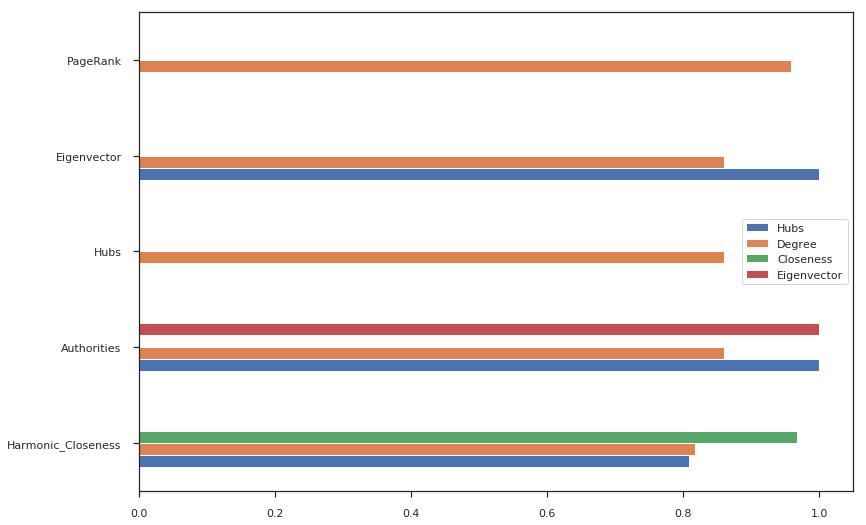

In [227]:
corr_centralities(measuring(red_dimer_sin_cofact), m=10).unstack(0).plot.barh()

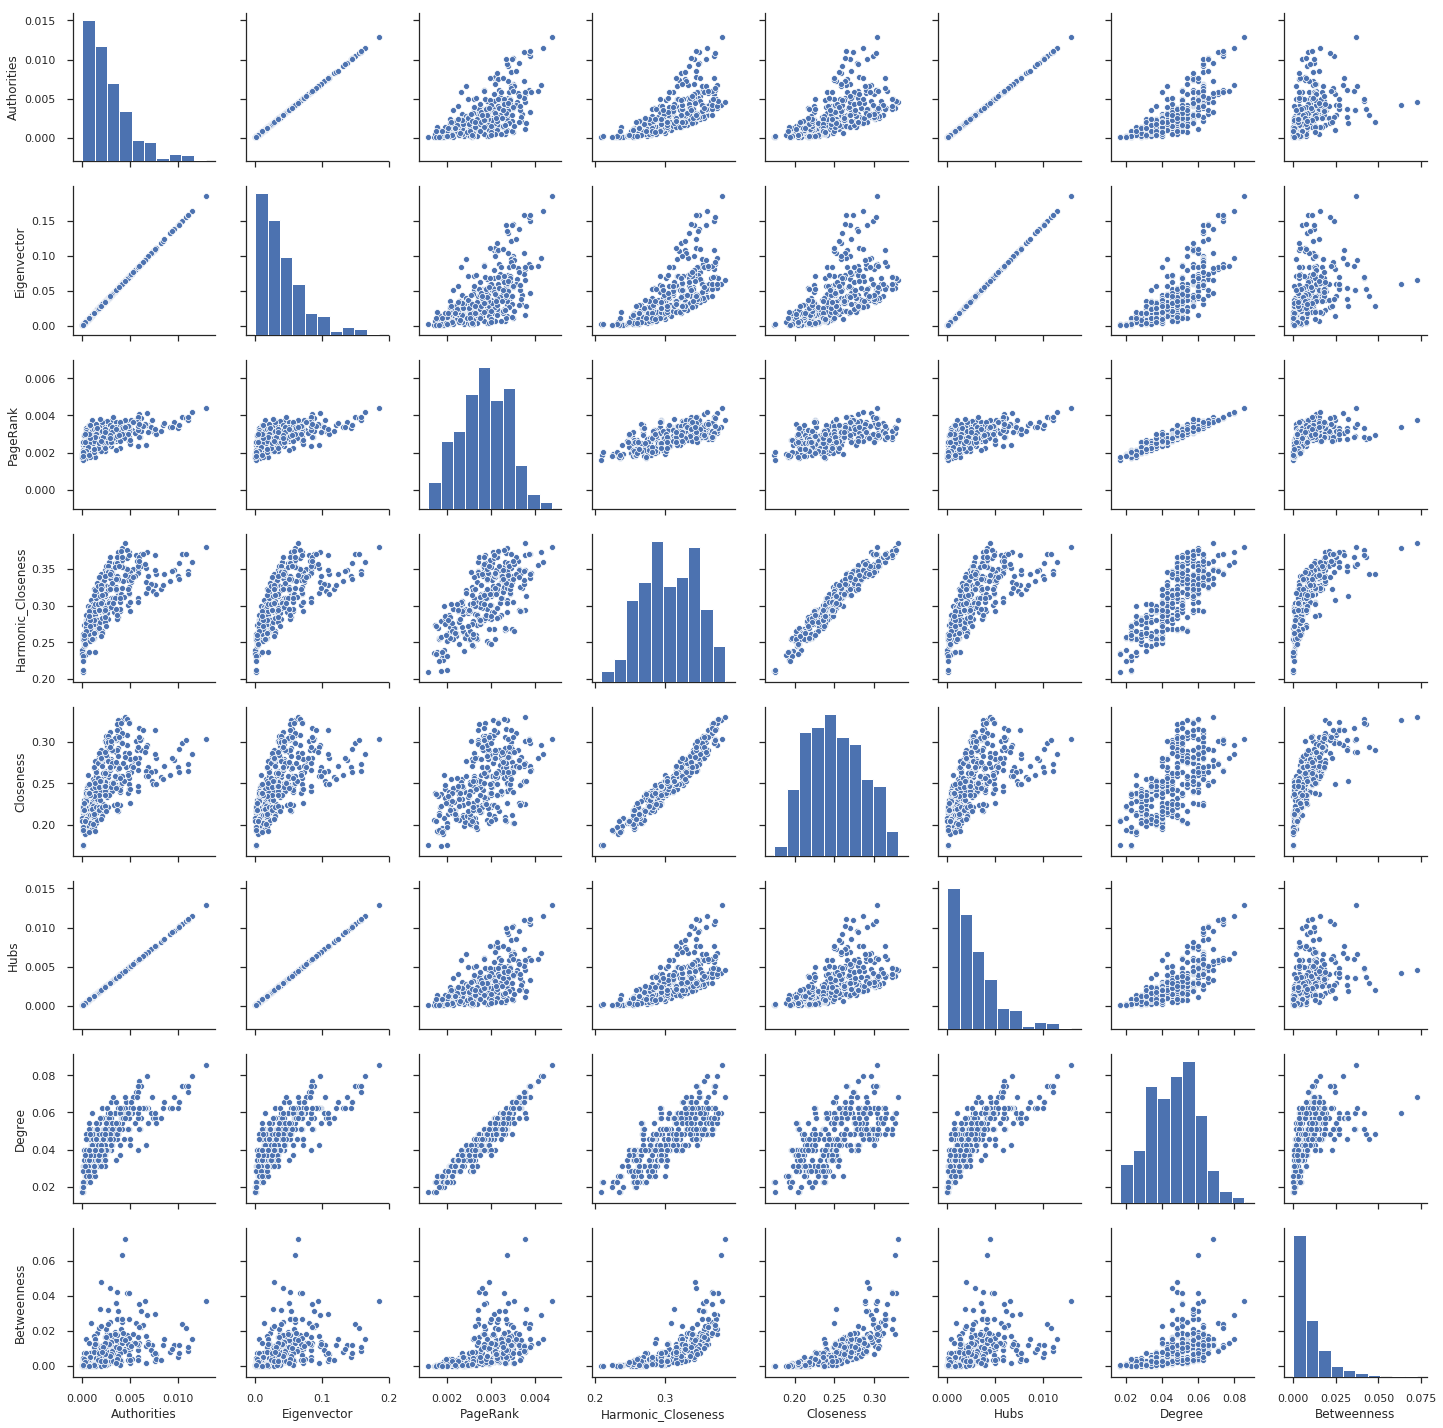

In [228]:
sns.set(style="ticks")
sns.pairplot(df_measuring)

In [229]:
# for i in df_measuring.columns:
#     for j in df_measuring.columns:
#         plot_centralities(df_measuring,i,j)

## Analsis de comunidades

In [230]:
part = community.best_partition(red_dimer_sin_cofact)

In [231]:
community.modularity(part,red_dimer_sin_cofact)

0.6058759181122051

In [232]:
induced = community.induced_graph(part, red_dimer_sin_cofact)

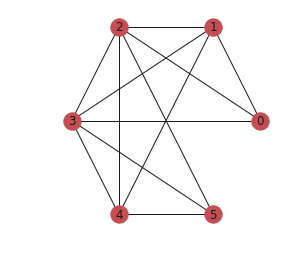

In [234]:
plt.figure(figsize=(3,3))
nx.draw_circular(induced,with_labels=True)

In [235]:
top_bet = measuring(red_dimer_sin_cofact).sort_values('Betweenness', ascending=False).head(20).index.values

In [236]:
top_bet

array(['340', '140', '306', '342', '143', '106', '343', '144', '145',
       '304', '301', '159', '328', '346', '344', '104', '101', '105',
       '329', '359'], dtype=object)

In [237]:
# a que comunidad pertenecen los de mayor betweness
for i in top_bet:
    print(i,part[i])

340 3
140 2
306 3
342 3
143 2
106 0
343 3
144 3
145 0
304 3
301 4
159 0
328 2
346 5
344 4
104 0
101 1
105 0
329 4
359 3


Text(0,0.5,'comunidad')

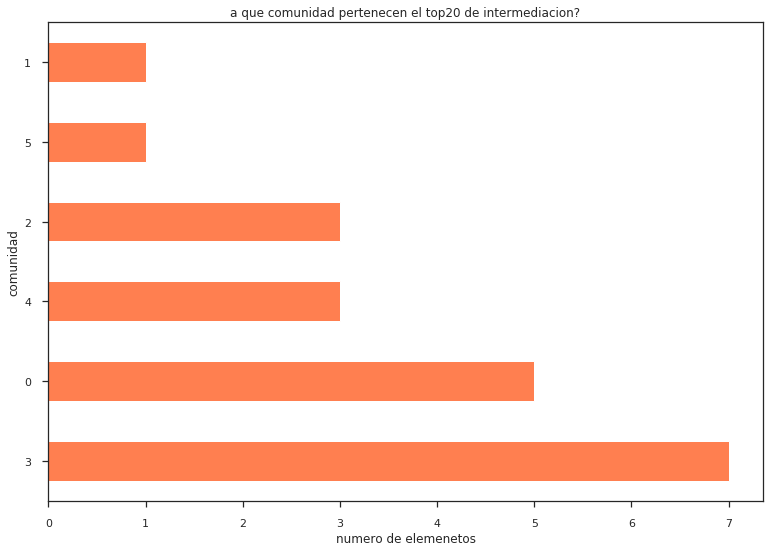

In [238]:
pd.DataFrame([(i,part[i]) for i in top_bet ]).set_index(0)[1].value_counts().plot.barh(
    title='a que comunidad pertenecen el top20 de intermediacion?', color='coral')
plt.xlabel('numero de elemenetos')
plt.ylabel('comunidad')

In [239]:
df_measuring.describe()

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.002841,0.040815,0.002841,0.305581,0.250578,0.002841,0.046021,0.008762
std,0.002389,0.034327,0.000550,0.038214,0.034391,0.002389,0.013272,0.010098
min,0.000068,0.000984,0.001576,0.208950,0.174367,0.000068,0.017094,0.000000
25%,0.001054,0.015141,0.002482,0.276629,0.222222,0.001054,0.037037,0.001747
50%,0.002273,0.032655,0.002853,0.303937,0.248672,0.002273,0.045584,0.004940
75%,0.003865,0.055535,0.003277,0.338327,0.277690,0.003865,0.056980,0.012534
max,0.012895,0.185268,0.004391,0.384848,0.330198,0.012895,0.085470,0.072757


In [240]:
df_measuring.loc[top_bet]

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
340,0.004512,0.064825,0.003769,0.384848,0.330198,0.004512,0.068376,0.072757
140,0.004171,0.059920,0.003370,0.378409,0.326816,0.004171,0.059829,0.063190
306,0.002934,0.042159,0.002790,0.343351,0.293724,0.002934,0.045584,0.044391
342,0.004748,0.068211,0.003298,0.375521,0.327425,0.004748,0.059829,0.041465
143,0.003713,0.053342,0.002724,0.365909,0.322018,0.003713,0.048433,0.042443
106,0.002000,0.028729,0.002964,0.342431,0.290804,0.002000,0.048433,0.048209
343,0.004891,0.070273,0.002859,0.368324,0.322314,0.004891,0.051282,0.041748
144,0.003647,0.052398,0.002717,0.359943,0.313953,0.003647,0.048433,0.026604
145,0.003568,0.051264,0.002890,0.353314,0.302326,0.003568,0.051282,0.036182
304,0.006586,0.094622,0.003525,0.357170,0.288177,0.006586,0.062678,0.037162


Text(0,0.5,'Comunidad')

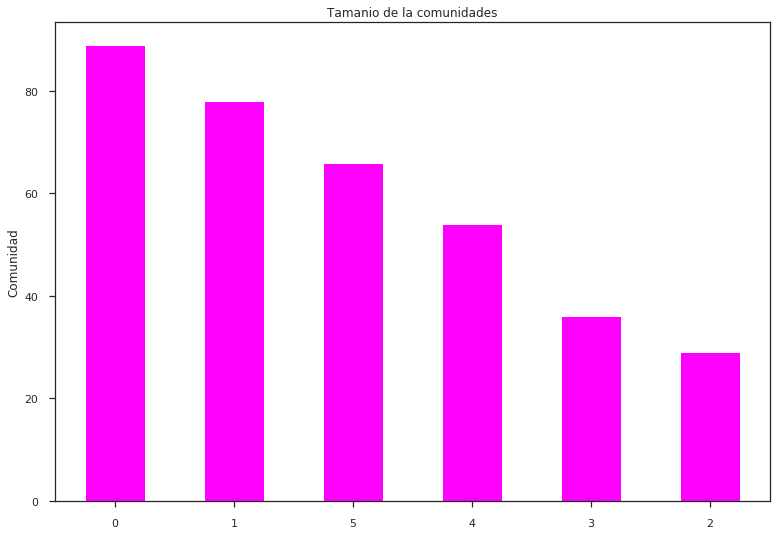

In [241]:
pd.Series(part).value_counts().plot.bar(rot=0, title='Tamanio de la comunidades', color='magenta')
plt.ylabel('Numero de nodos')
plt.ylabel('Comunidad')

-------

## tetra con cofact Red

### Metricas globales

In [242]:
print(nx.info(red_tetra_con_cofact))

Name: tetra_con_cofact_clean2_click
Type: Graph
Number of nodes: 352
Number of edges: 2829
Average degree:  16.0739


In [243]:
# densidad, porcentaje de enlaces de todos los posibles que puede haber. #Densidad baja#
nx.density(red_tetra_con_cofact)

0.045794483294483296

In [244]:
# clustering promedio
nx.average_clustering(red_tetra_con_cofact)

0.5612695500698782

In [245]:
# promedio de camnino mas corto
nx.average_shortest_path_length(red_tetra_con_cofact)

4.080209142709143

In [246]:
# porcentaje de triangulos existentes de todos los posibles tringulos posibles
nx.transitivity(red_tetra_con_cofact)

0.5050729435888673

no es una red aleatoria, no cumple todas las propiedades de ella, como clustering y promedio de camino mas corto

In [247]:
# el camino mas largo entre todos los caminos posibles sobre cada par de nodos
nx.diameter(red_tetra_con_cofact)

9

In [248]:
# el camino mas corto sobre todos los caminos mas largos de los caminos posibles de cada par de nodos
nx.radius(red_tetra_con_cofact)

5

In [249]:
# excentricidad es la maxima distancia de un nodo a todos los demas en la red
# nodos con una excentricidad igual al radio

nx.center(red_tetra_con_cofact)

['145',
 '128',
 '129',
 '144',
 '143',
 '140',
 '112',
 '141',
 '142',
 '340',
 '341',
 '328',
 '329',
 '342',
 '343',
 '344',
 '345',
 '312']

In [250]:
df = pd.DataFrame([i for i in red_tetra_con_cofact.degree], columns=['node_id','degree'])
df.head()

,node_id,degree
0,2,8
1,3,13
2,4,11
3,174,17
4,175,14


In [251]:
# grado promedio
df.mean()

node_id          inf
degree     16.073864
dtype: float64

Text(0.5,1,'Boxplot del grado, no se observan outliers')

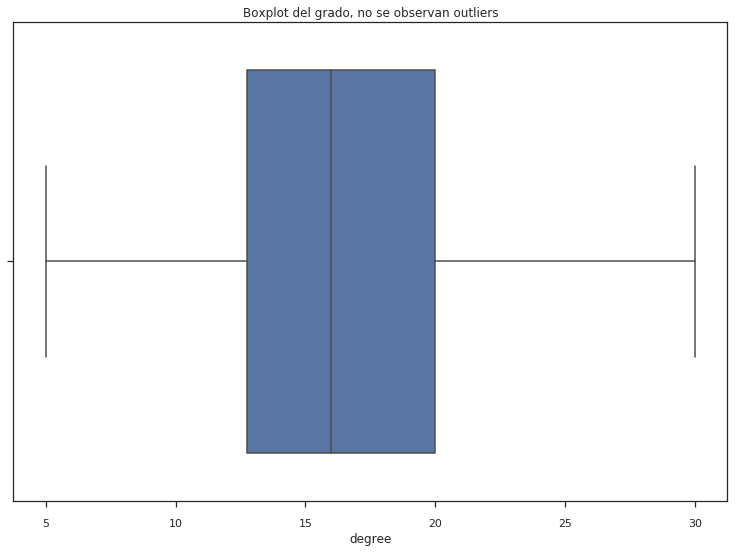

In [252]:
sns.boxplot(data=df,x='degree')
plt.title('Boxplot del grado, no se observan outliers')

Text(0.5,0,'grado')

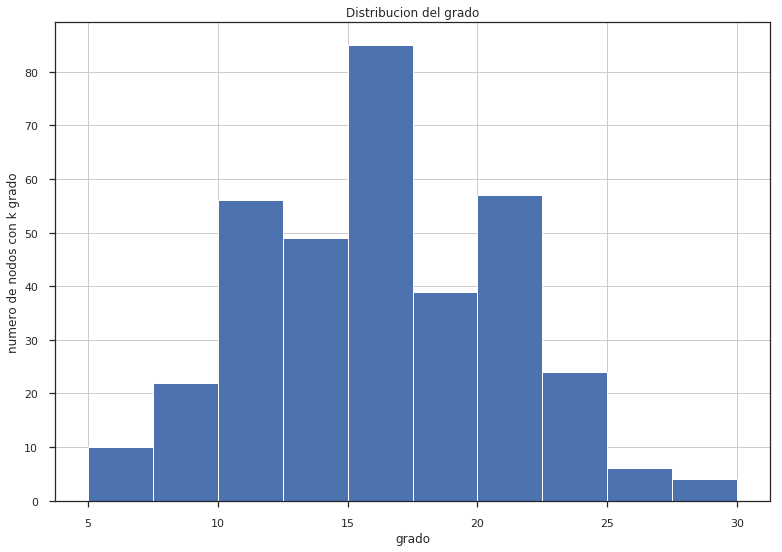

In [253]:
df.degree.hist()
plt.title('Distribucion del grado')
plt.ylabel('numero de nodos con k grado')
plt.xlabel('grado')

La distribucion del grado parece una normal.

Text(16.0739,0.081,'grado promedio')

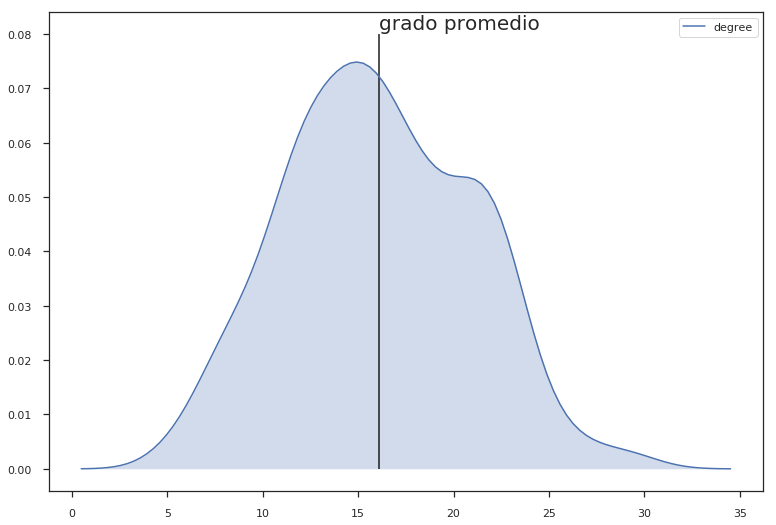

In [254]:
sns.kdeplot(df.degree, shade=True)
plt.vlines(df.degree.mean(),0,0.08)
plt.text(df.degree.mean(),0.081,'grado promedio',fontsize=20)

In [255]:
measuring(red_tetra_con_cofact).sort_values('Betweenness', ascending=False).head()

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
343,0.005862,0.082530,0.003374,0.391193,0.343444,0.005862,0.062678,0.078656
342,0.006390,0.089961,0.003701,0.399100,0.351000,0.006390,0.068376,0.062269
142,0.006793,0.095634,0.003650,0.397680,0.349602,0.006793,0.068376,0.055650
145,0.006984,0.098320,0.002939,0.372538,0.322314,0.006984,0.054131,0.053554
140,0.005137,0.072316,0.003449,0.383286,0.332701,0.005137,0.062678,0.052827


In [257]:
pd.read_csv('networks_scripts/data_csv/tetra_con_cofact.csv').sort_values('betweenesscentrality', ascending=False).head()

,Id,Label,timeset,degree,weighted degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,modularity_class,clustering,triangles
177,343,343,NaN,22,22,5,0.343444,0.392308,0.078656,2,0.406926,94
176,342,342,NaN,24,24,5,0.351000,0.400237,0.062269,5,0.387681,107
160,142,142,NaN,24,24,5,0.349602,0.398813,0.055650,2,0.413043,114
54,145,145,NaN,19,19,5,0.322314,0.373599,0.053554,0,0.485380,83
156,140,140,NaN,22,22,5,0.332701,0.384378,0.052827,2,0.419913,97


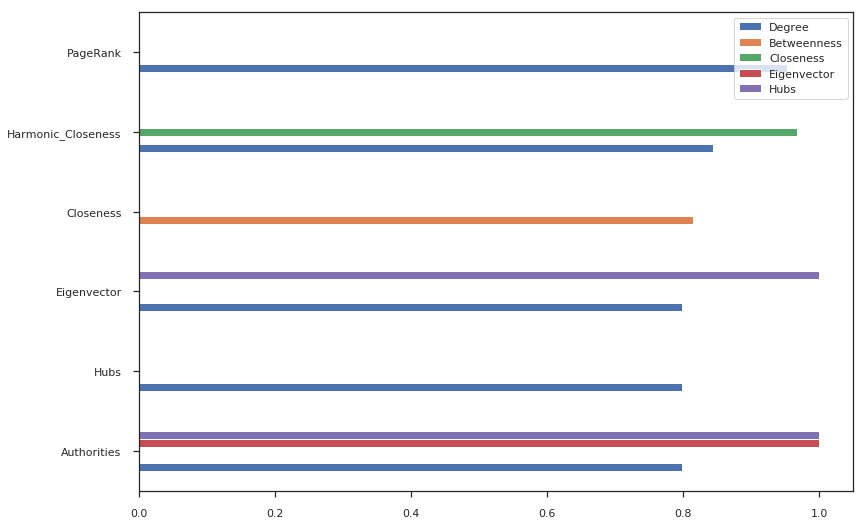

In [258]:
corr_centralities(measuring(red_tetra_con_cofact), m=10).unstack(0).plot.barh()

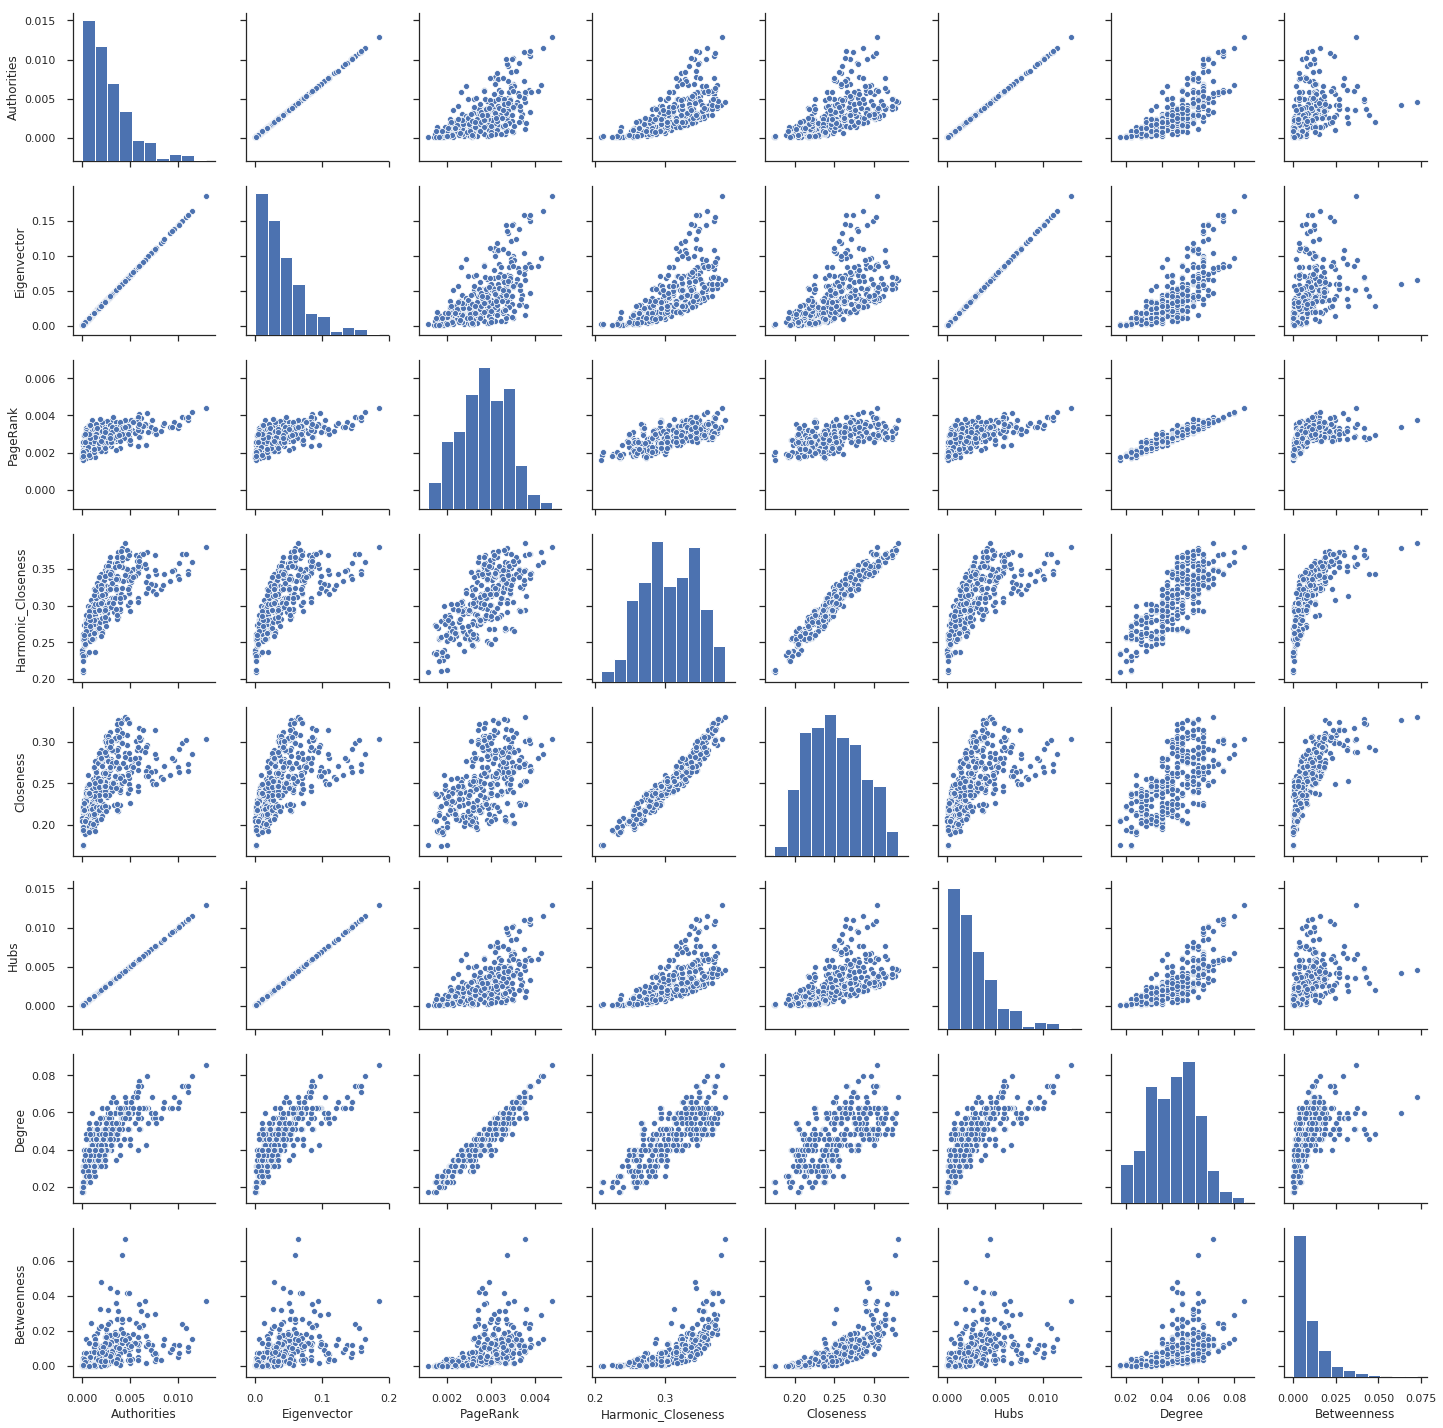

In [259]:
sns.set(style="ticks")
sns.pairplot(df_measuring)

In [260]:
# for i in df_measuring.columns:
#     for j in df_measuring.columns:
#         plot_centralities(df_measuring,i,j)

## Analsis de comunidades

In [261]:
part = community.best_partition(red_tetra_con_cofact)

In [262]:
community.modularity(part,red_tetra_con_cofact)

0.6194353637482615

In [263]:
induced = community.induced_graph(part, red_tetra_con_cofact)

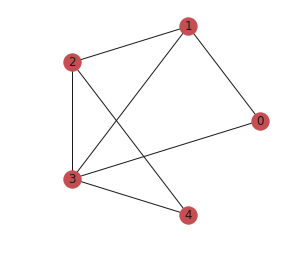

In [265]:
plt.figure(figsize=(3,3))
nx.draw_circular(induced,with_labels=True)

In [266]:
top_bet = measuring(red_tetra_con_cofact).sort_values('Betweenness', ascending=False).head(20).index.values

In [267]:
top_bet

array(['343', '342', '142', '145', '140', '143', '345', '340', '144',
       '141', '359', '344', '159', '306', '305', '138', '330', '106',
       '130', '301'], dtype=object)

In [268]:
# a que comunidad pertenecen los de mayor betweness
for i in top_bet:
    print(i,part[i])

343 3
342 2
142 3
145 1
140 3
143 3
345 3
340 2
144 1
141 3
359 4
344 3
159 0
306 2
305 2
138 3
330 3
106 0
130 1
301 3


Text(0,0.5,'comunidad')

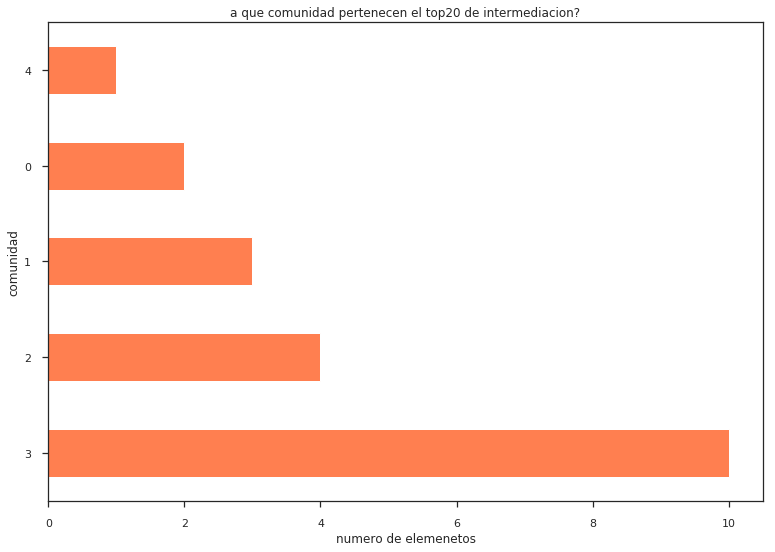

In [269]:
pd.DataFrame([(i,part[i]) for i in top_bet ]).set_index(0)[1].value_counts().plot.barh(
    title='a que comunidad pertenecen el top20 de intermediacion?', color='coral')
plt.xlabel('numero de elemenetos')
plt.ylabel('comunidad')

In [270]:
df_measuring.describe()

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.002841,0.040815,0.002841,0.305581,0.250578,0.002841,0.046021,0.008762
std,0.002389,0.034327,0.000550,0.038214,0.034391,0.002389,0.013272,0.010098
min,0.000068,0.000984,0.001576,0.208950,0.174367,0.000068,0.017094,0.000000
25%,0.001054,0.015141,0.002482,0.276629,0.222222,0.001054,0.037037,0.001747
50%,0.002273,0.032655,0.002853,0.303937,0.248672,0.002273,0.045584,0.004940
75%,0.003865,0.055535,0.003277,0.338327,0.277690,0.003865,0.056980,0.012534
max,0.012895,0.185268,0.004391,0.384848,0.330198,0.012895,0.085470,0.072757


In [271]:
df_measuring.loc[top_bet]

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
343,0.004891,0.070273,0.002859,0.368324,0.322314,0.004891,0.051282,0.041748
342,0.004748,0.068211,0.003298,0.375521,0.327425,0.004748,0.059829,0.041465
142,0.003783,0.054353,0.003038,0.372964,0.326816,0.003783,0.054131,0.018528
145,0.003568,0.051264,0.002890,0.353314,0.302326,0.003568,0.051282,0.036182
140,0.004171,0.059920,0.003370,0.378409,0.326816,0.004171,0.059829,0.063190
143,0.003713,0.053342,0.002724,0.365909,0.322018,0.003713,0.048433,0.042443
345,0.004962,0.071286,0.002624,0.338542,0.286297,0.004962,0.045584,0.016078
340,0.004512,0.064825,0.003769,0.384848,0.330198,0.004512,0.068376,0.072757
144,0.003647,0.052398,0.002717,0.359943,0.313953,0.003647,0.048433,0.026604
141,0.004891,0.070262,0.003168,0.372348,0.323502,0.004891,0.056980,0.026622


Text(0,0.5,'Comunidad')

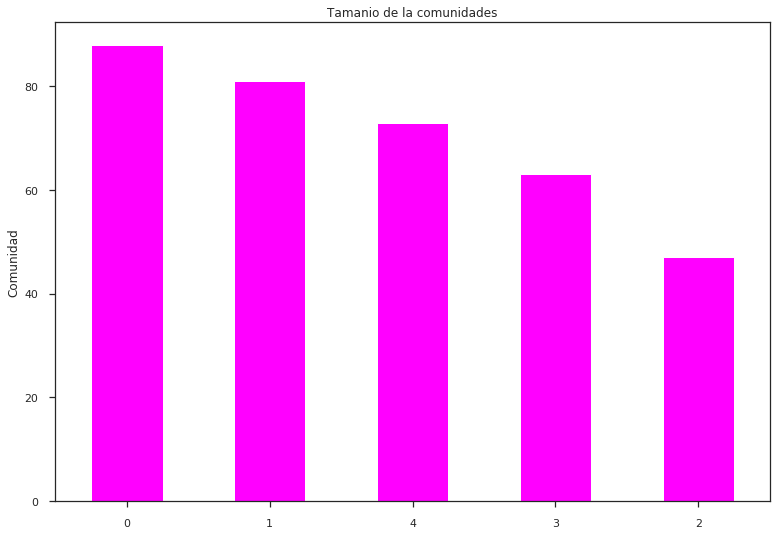

In [272]:
pd.Series(part).value_counts().plot.bar(rot=0, title='Tamanio de la comunidades', color='magenta')
plt.ylabel('Numero de nodos')
plt.ylabel('Comunidad')

--------

## Tetra sin cofact Red

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
import seaborn as sns

### Metricas globales

In [8]:
print(nx.info(red_tetra_sin_cofact))

Name: tetra_sin_cofact_clean
Type: Graph
Number of nodes: 352
Number of edges: 2777
Average degree:  15.7784


In [9]:
# densidad, porcentaje de enlaces de todos los posibles que puede haber. #Densidad baja#
nx.density(red_tetra_sin_cofact)

0.04495273245273245

In [10]:
# clustering promedio
nx.average_clustering(red_tetra_sin_cofact)

0.5619867676443651

In [11]:
# promedio de camnino mas corto
nx.average_shortest_path_length(red_tetra_sin_cofact)

4.142838642838643

In [12]:
# porcentaje de triangulos existentes de todos los posibles tringulos posibles
nx.transitivity(red_tetra_sin_cofact)

0.5057823879938204

no es una red aleatoria, no cumple todas las propiedades de ella, como clustering y promedio de camino mas corto

In [13]:
# el camino mas largo entre todos los caminos posibles sobre cada par de nodos
nx.diameter(red_tetra_sin_cofact)

9

In [14]:
# el camino mas corto sobre todos los caminos mas largos de los caminos posibles de cada par de nodos
nx.radius(red_tetra_sin_cofact)

5

In [15]:
# excentricidad es la maxima distancia de un nodo a todos los demas en la red
# nodos con una excentricidad igual al radio

nx.center(red_tetra_sin_cofact)

[145, 128, 143, 144, 140, 141, 142, 340, 341, 328, 342, 343, 344, 312]

In [16]:
df = pd.DataFrame([i for i in red_tetra_sin_cofact.degree], columns=['node_id','degree'])
df.head()

,node_id,degree
0,2,8
1,3,13
2,4,10
3,175,14
4,5,12


In [17]:
# grado promedio
df.mean()

node_id    189.500000
degree      15.778409
dtype: float64

Text(0.5,1,'Boxplot del grado, no se observan outliers')

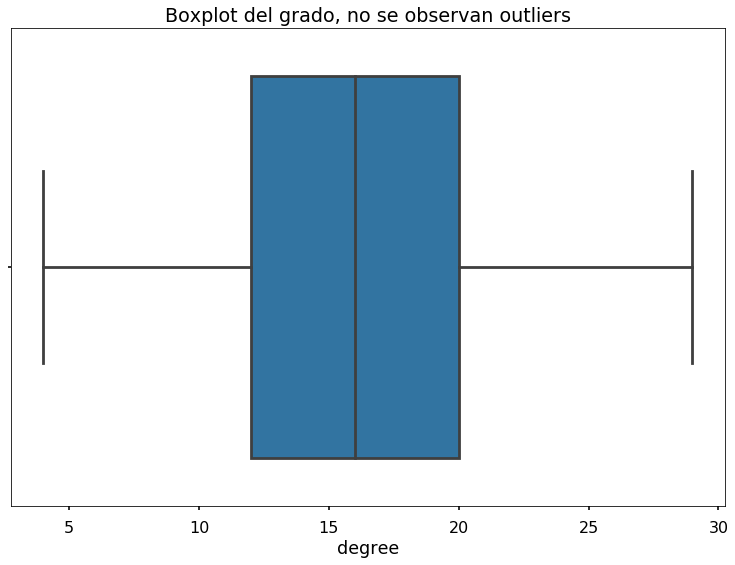

In [18]:
sns.boxplot(data=df,x='degree')
plt.title('Boxplot del grado, no se observan outliers')

Text(0.5,0,'grado')

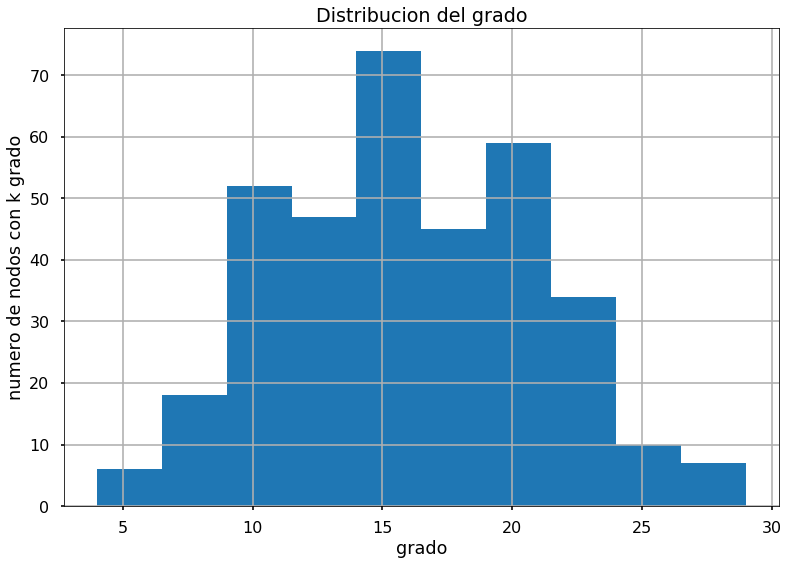

In [19]:
df.degree.hist()
plt.title('Distribucion del grado')
plt.ylabel('numero de nodos con k grado')
plt.xlabel('grado')

La distribucion del grado parece una normal.

Text(15.7784,0.081,'grado promedio')

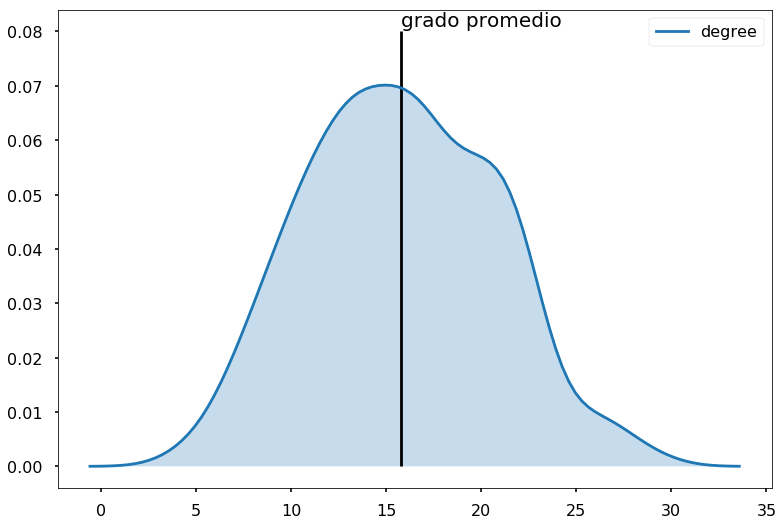

In [20]:
sns.kdeplot(df.degree, shade=True)
plt.vlines(df.degree.mean(),0,0.08)
plt.text(df.degree.mean(),0.081,'grado promedio',fontsize=20)

In [21]:
# No jala! con eigenvector ni con hits
def measuring(red):
    dgr = nx.degree_centrality(red)
    clo = nx.closeness_centrality(red)
    har = nx.harmonic_centrality(red)
    eig = nx.eigenvector_centrality_numpy(red)
    bet = nx.betweenness_centrality(red)
    pgr = nx.pagerank(red)
    hits = nx.hits_numpy(red)
    
    centralities = pd.concat(
    [pd.Series(c) for c in (hits[1],eig,pgr,har,clo,hits[0],dgr,bet)],
    axis=1)
    centralities.columns = ["Authorities","Eigenvector", "PageRank",
                           "Harmonic_Closeness", "Closeness","Hubs",
                           "Degree", "Betweenness"]
    centralities["Harmonic_Closeness"] /= centralities.shape[0]
    
    return centralities

In [23]:
measuring(red_tetra_sin_cofact).sort_values('Betweenness', ascending=False).head()

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
143,0.007644,0.102518,0.003562,0.382102,0.331445,0.007644,0.065527,0.060460
140,0.003967,0.053201,0.003419,0.375521,0.326208,0.003967,0.059829,0.056869
142,0.005790,0.077652,0.003489,0.388068,0.341440,0.005790,0.062678,0.054672
342,0.005714,0.076637,0.003472,0.379214,0.330820,0.005714,0.062678,0.050178
340,0.005781,0.077536,0.003530,0.377273,0.327731,0.005781,0.062678,0.049742


In [24]:
measuring(red_tetra_sin_cofact).sort_values('Degree', ascending=False).head()

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
101,0.014411,0.193277,0.004278,0.373769,0.295455,0.014411,0.082621,0.029769
301,0.005445,0.073028,0.004339,0.372727,0.296453,0.005445,0.082621,0.035074
300,0.005044,0.067655,0.004092,0.362926,0.293233,0.005044,0.076923,0.020357
130,0.012620,0.169253,0.004017,0.377320,0.307625,0.012620,0.076923,0.034117
47,0.012758,0.171102,0.004051,0.347491,0.265708,0.012758,0.076923,0.012756


In [25]:
def corr_centralities(df_measuring, m=10):
    c_df = df_measuring.corr()
    ll_triangle = np.tri(c_df.shape[0], k=-1)
    c_df *= ll_triangle
    c_series = c_df.stack().sort_values().tail(m)
    return c_series

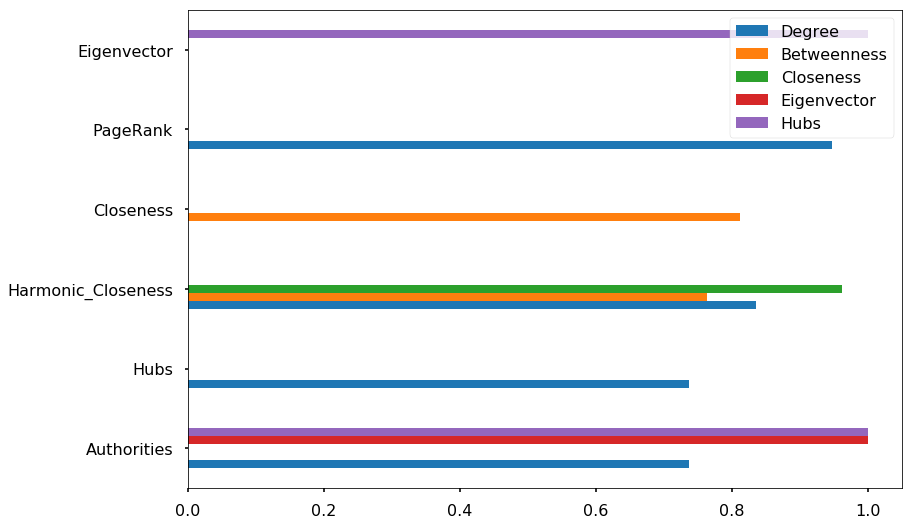

In [26]:
corr_centralities(measuring(red_tetra_sin_cofact), m=10).unstack(0).plot.barh()

In [27]:
def plot_centralities(df_measuring,col1,col2):
    X=col1
    Y=col2
    limits = pd.concat([df_measuring[[X,Y]].min(),df_measuring[[X,Y]].max()], axis=1).values
    df_measuring.plot(kind='scatter', x=X, y=Y, xlim=limits[0],ylim=limits[1],s=75,logy=False,alpha=0.6)

In [30]:
df_measuring = measuring(red_tetra_sin_cofact)

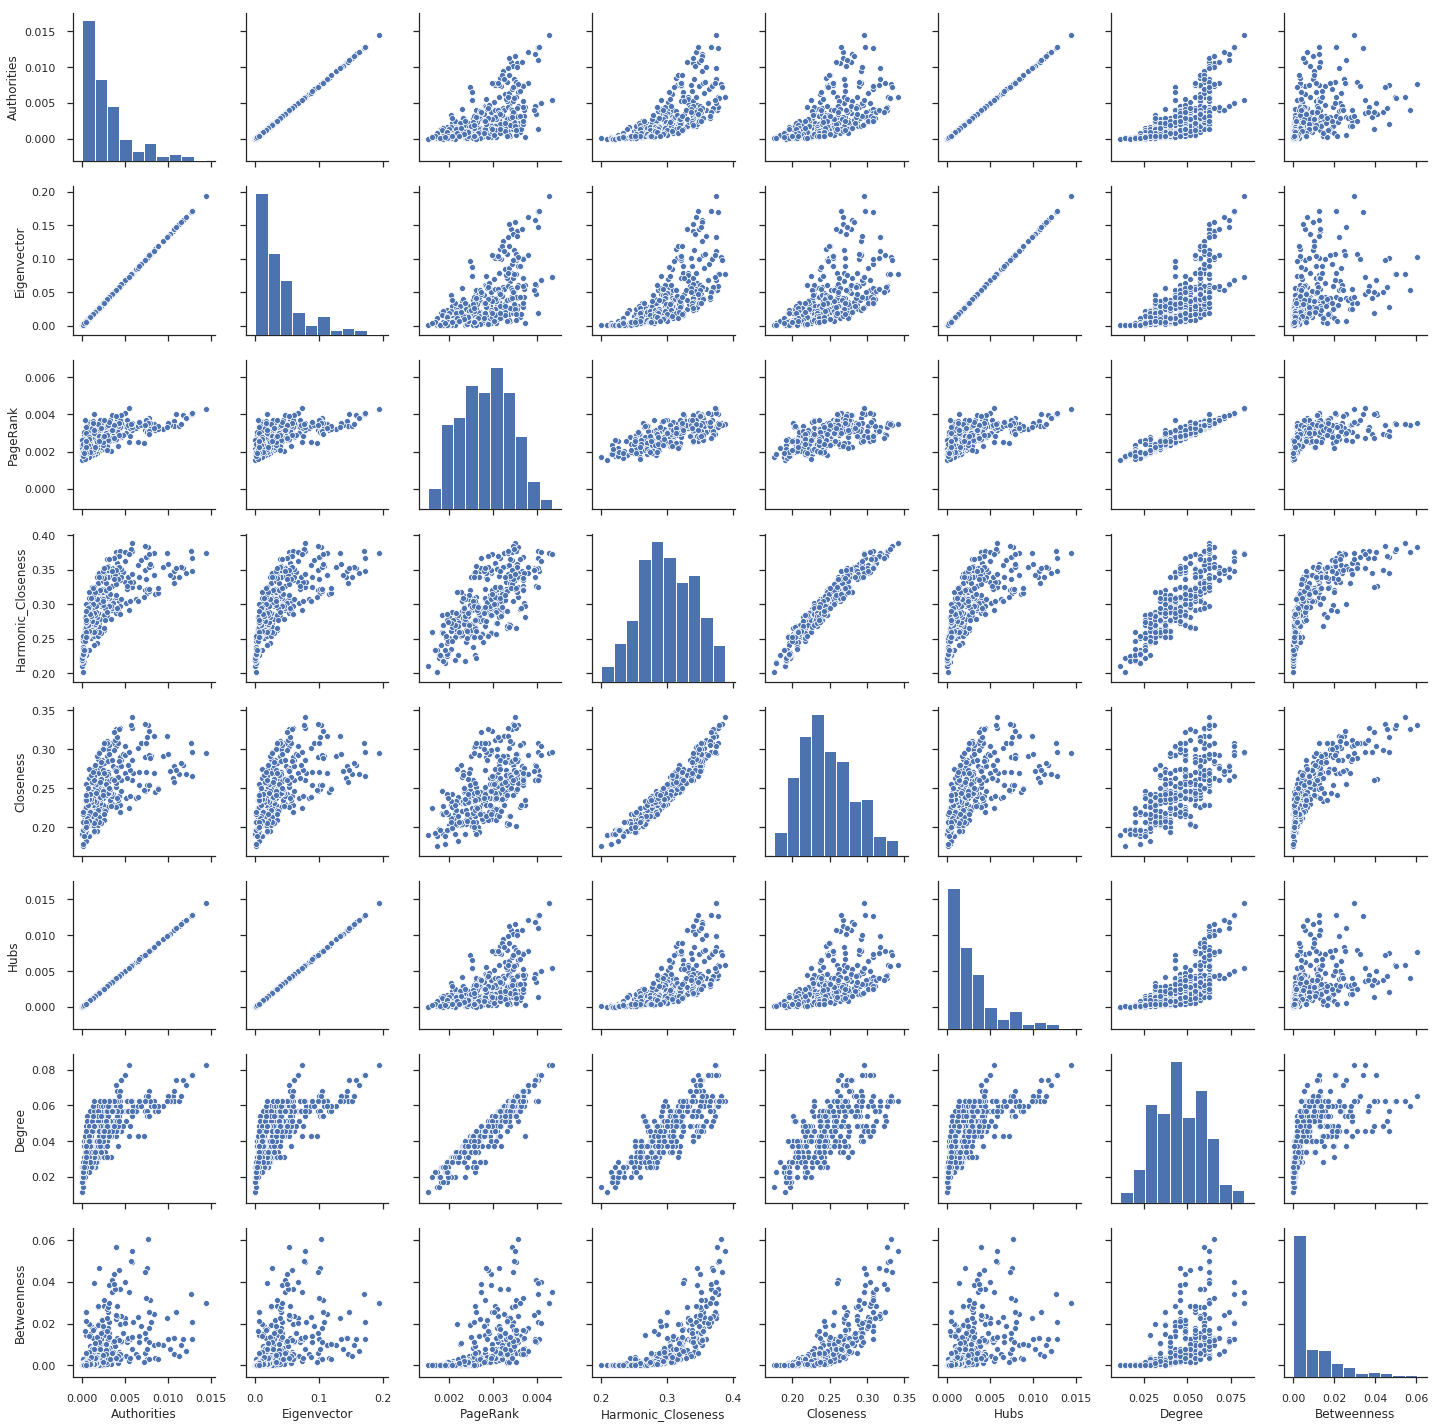

In [31]:
sns.set(style="ticks")
sns.pairplot(df_measuring)

In [32]:
# for i in df_measuring.columns:
#     for j in df_measuring.columns:
#         plot_centralities(df_measuring,i,j)

## Analsis de comunidades

In [35]:
import community

In [36]:
part = community.best_partition(red_tetra_sin_cofact)

In [37]:
community.modularity(part,red_tetra_sin_cofact)

0.6186979599516529

In [38]:
induced = community.induced_graph(part, red_tetra_sin_cofact)

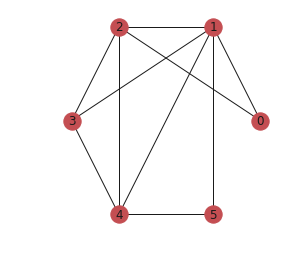

In [39]:
plt.figure(figsize=(3,3))
nx.draw_circular(induced,with_labels=True)

In [40]:
top_bet = measuring(red_tetra_sin_cofact).sort_values('Betweenness', ascending=False).head(20).index.values

In [41]:
top_bet

array([143, 140, 142, 342, 340, 306, 145, 343, 341, 106, 159, 330, 359,
       344, 109, 141, 328, 338, 301, 130])

In [42]:
# a que comunidad pertenecen los de mayor betweness
for i in top_bet:
    print(i,part[i])

143 2
140 2
142 2
342 2
340 1
306 3
145 1
343 2
341 1
106 2
159 0
330 4
359 3
344 2
109 2
141 2
328 2
338 1
301 4
130 1


Text(0,0.5,'comunidad')

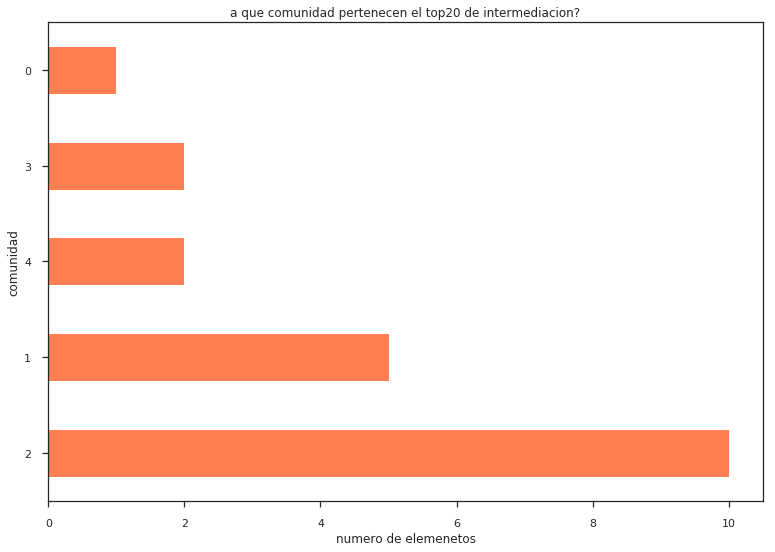

In [43]:
pd.DataFrame([(i,part[i]) for i in top_bet ]).set_index(0)[1].value_counts().plot.barh(
    title='a que comunidad pertenecen el top20 de intermediacion?', color='coral')
plt.xlabel('numero de elemenetos')
plt.ylabel('comunidad')

In [46]:
df_measuring.describe()

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.002841,0.038102,0.002841,0.300125,0.246275,0.002841,0.044953,0.008980
std,0.002783,0.037325,0.000586,0.040459,0.035382,0.002783,0.014054,0.011547
min,0.000035,0.000464,0.001531,0.201097,0.175940,0.000035,0.011396,0.000000
25%,0.000847,0.011363,0.002388,0.270444,0.218013,0.000847,0.034188,0.001178
50%,0.001972,0.026449,0.002857,0.297342,0.241154,0.001972,0.045584,0.003827
75%,0.003840,0.051508,0.003303,0.332564,0.270156,0.003840,0.056980,0.012757
max,0.014411,0.193277,0.004339,0.388068,0.341440,0.014411,0.082621,0.060460


In [47]:
df_measuring.loc[top_bet]

,Authorities,Eigenvector,PageRank,Harmonic_Closeness,Closeness,Hubs,Degree,Betweenness
143,0.007644,0.102518,0.003562,0.382102,0.331445,0.007644,0.065527,0.060460
140,0.003967,0.053201,0.003419,0.375521,0.326208,0.003967,0.059829,0.056869
142,0.005790,0.077652,0.003489,0.388068,0.341440,0.005790,0.062678,0.054672
342,0.005714,0.076637,0.003472,0.379214,0.330820,0.005714,0.062678,0.050178
340,0.005781,0.077536,0.003530,0.377273,0.327731,0.005781,0.062678,0.049742
306,0.002033,0.027266,0.002837,0.345028,0.296203,0.002033,0.045584,0.046592
145,0.007559,0.101379,0.003135,0.368466,0.315932,0.007559,0.056980,0.046520
343,0.004288,0.057504,0.002886,0.369602,0.325301,0.004288,0.051282,0.045681
341,0.007282,0.097666,0.003443,0.383475,0.332701,0.007282,0.062678,0.044567
106,0.003763,0.050474,0.002949,0.349953,0.298469,0.003763,0.048433,0.043868


Text(0,0.5,'Comunidad')

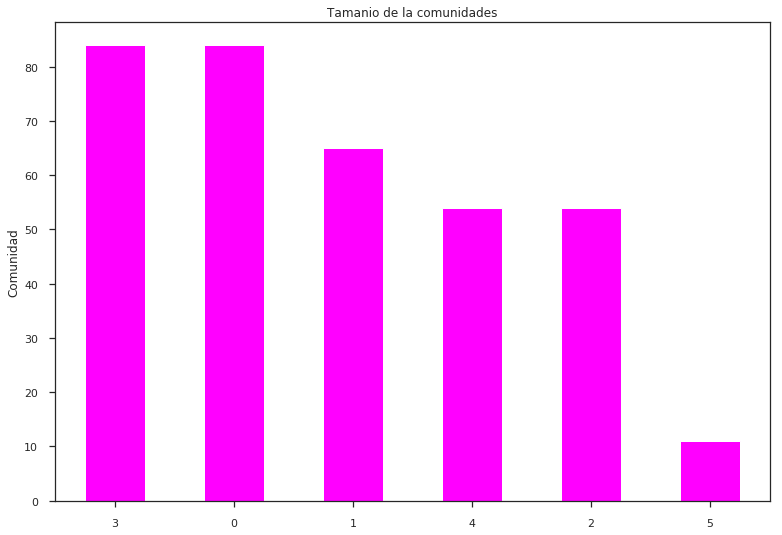

In [48]:
pd.Series(part).value_counts().plot.bar(rot=0, title='Tamanio de la comunidades', color='magenta')
plt.ylabel('Numero de nodos')
plt.ylabel('Comunidad')

------

# SCRIPT POR CACHOS QUE AYUDO A CREAR LA FUNCION INICIAL

In [3]:
# lectura de archivo
file1 = '/home/serch/pdbmani/Serch/pdbs/dimer_con_cofact_clean.pdb'  # dime_out no es trayectoria es pdb

# se define la estructura
trj1 = rpt.Trajectory(file1)

# se lee el pdb y se agrega al objeto
trj1.ReadTraj("%s" % file1)

trj11 = trj1.frames

# set center_mass calculando aqui tarda un poco
for pdbstruct in trj11:
    pdbstruct.set_center_mass()

In [4]:
def get_df_distancias(ref):
    """Funcion para obtener los enlaces de distancias de cada residuo
    Dudas en codigo pueden revisar fc.distancia_entre_atomos en ese se basa
    esta funcion, la diferencia es que se crea con el objeto residuo"""
    # se generan listas con coordenadas y numero de atomo
#     enlaces = [ [res1.resi, res2.resi] for res1 in ref[1:-1] for res2 in ref[1:-1] 
#                if res2.resi >= res1.resi if mymath.distance(res2.GetAtom('CA').coord, res1.GetAtom('CA').coord) < 10
#               ]

    enlaces = []
    for res1 in ref:
        for res2 in ref:
            if res1.resi in [1,178, 201,378] or res2.resi in [1, 178, 201,378]: # se hizo a  mano el quitar los atomos que no nos interesn
                continue
            else:
                if res2.resi >= res1.resi:
                    dist = mymath.distance(res2.GetAtom('CA').coord, res1.GetAtom('CA').coord)
                    if  dist < 10:
                        enlaces.append([res1.resi, res2.resi])

    # se genera la matriz de adyacencias para la red
    return enlaces

In [7]:
%%time

pdbs = [pdb.GetResChain() for pdb in trj11]

enlaces = [get_df_distancias(residues) for residues in pdbs]
# aqui se filtran los enlaces

CPU times: user 3min 14s, sys: 136 ms, total: 3min 14s
Wall time: 3min 14s


In [8]:
from collections import Counter # obtener conteo de enlaces
a = Counter([str(j) for i in enlaces for j in i]).most_common()

import ast # para pasar de str a tupla o listas
red_promedio = nx.Graph([ast.literal_eval(i[0]) for i in a if (i[1] / len(enlaces)) > 0.7])

print(nx.info(red_promedio))

trj11[0].PrintPdbInfo()

Name: 
Type: Graph
Number of nodes: 352
Number of edges: 3195
Average degree:  18.1534
Number of residues and frame: 356    1
Number of chains:             1  dict_keys(['A'])


In [9]:
red_promedio

--------------

# Genera red y subred de vecinos secundarios para Dimero de interes

In [65]:
%time
#!/usr/bin/env python

# librerias que utilizaras
import numpy as np
# por si no te lee las tools o functions creadas
import sys
sys.path.append("/home/serch/pdbmani/Serch/math_tricks/")
sys.path.append("/home/serch/pdbmani/Serch/")
import math_vect_tools as mymath
# herramientas para leer pdbs
import read_pdb_tools as rpt
# funciones de click generadas en pandas
import funciones_CLICK as fc
# cuenta tiempo de ejecucion
import datetime
time_all = datetime.datetime.now()
# networks
import networkx as nx
import os
os.chdir('/home/serch/pdbmani/Serch')


# lectura de archivo
file1 = '/home/serch/pdbmani/Serch/pdbs/dime_out.pdb'  # dime_out no es trayectoria es pdb

# se define la estructura
pdb1 = rpt.PdbStruct(file1)

# se lee el pdb y se agrega al objeto
pdb1.AddPdbData("%s" % file1)

pdb1.set_center_mass()

pdb1.Set_SS()

pdb1.GetNeighbors()

pdb11 = pdb1.GetResChain()

def get_df_distancias(ref):
    """Funcion para obtener los enlaces de distancias de cada residuo
    Dudas en codigo pueden revisar fc.distancia_entre_atomos en ese se basa
    esta funcion, la diferencia es que se crea con el objeto residuo"""
    # se generan listas con coordenadas y numero de atomo

    # calcula distancia y regresa dataframe
    enlaces = []
    for res1 in ref[1:-1]:
        for res2 in ref[1:-1]:
            if res2.resi >= res1.resi:
                dist = mymath.distance(res2.GetAtom('CA').coord, res1.GetAtom('CA').coord)
                if dist < 10 and dist != 0:
                    enlaces.append([res1.resi, res2.resi])

    # se genera la matriz de adyacencias para la red
    return enlaces

enlaces = get_df_distancias(pdb11)
# red de todo el dimero.
red = nx.Graph(enlaces)
nx.set_edge_attributes(red, 'red', name='color')

# nx.write_gexf(red, 'r.gexf')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [20]:
# nx.write_gexf(red, 'r.gexf')

In [66]:
print(nx.info(red))

Name: 
Type: Graph
Number of nodes: 174
Number of edges: 1500
Average degree:  17.2414


In [34]:
# funcion subred segundos vecinos
def get_second_nei(res, flag_write=False):
    first_nei = pdb1.GetRes(res).ngb
    list_second_nei = [pdb1.GetRes(residue).ngb for residue in first_nei]
    set_second_nei = set([j for i in list_second_nei for j in i])
    sub_red = red.subgraph(set_second_nei)
    nx.set_edge_attributes(subred, 'blue', name='color')
    if flag_write:
        nx.write_gexf(sub_red, 'r1.gexf')
        return sub_red
    else:
        return sub_red

In [58]:
en1 = [i for i in get_second_nei(160).edges]
en2 = [i for i in get_second_nei(5).edges]

In [59]:
len(en1)

571

In [60]:
len(en2)

296

In [63]:
# que enlaces si estan en uno u otro residuo
len([i for i in en1 if i in en2])

264

In [64]:
# que enlaces si estan en uno u otro residuo
len([i for i in en1 if i not in en2])

307

# CHeck de red con articulo Perica

In [110]:
%time
#!/usr/bin/env python

# librerias que utilizaras
import numpy as np
# por si no te lee las tools o functions creadas
import sys
sys.path.append("/home/serch/pdbmani/Serch/math_tricks/")
sys.path.append("/home/serch/pdbmani/Serch/")
import math_vect_tools as mymath
# herramientas para leer pdbs
import read_pdb_tools as rpt
# funciones de click generadas en pandas
import funciones_CLICK as fc
# cuenta tiempo de ejecucion
import datetime
time_all = datetime.datetime.now()
# networks
import networkx as nx
import os
os.chdir('/home/serch/pdbmani/Serch')


# lectura de archivo
file1 = '/home/serch/pdbmani/Serch/networks_scripts/pdbs/4p81.pdb'  # dime_out no es trayectoria es pdb

# se define la estructura
pdb1 = rpt.PdbStruct(file1)

# se lee el pdb y se agrega al objeto
pdb1.AddPdbData("%s" % file1)

pdb1.set_center_mass()

pdb1.Set_SS()

pdb1.GetNeighbors()

pdb11 = pdb1.GetResChain()

def get_df_distancias(ref):
    """Funcion para obtener los enlaces de distancias de cada residuo
    Dudas en codigo pueden revisar fc.distancia_entre_atomos en ese se basa
    esta funcion, la diferencia es que se crea con el objeto residuo"""
    # se generan listas con coordenadas y numero de atomo

    # calcula distancia y regresa dataframe
    enlaces = []
    for res1 in ref[1:-1]:
        for res2 in ref[1:-1]:
            if res2.resi >= res1.resi:
                dist = mymath.distance(res2.GetAtom('CA').coord, res1.GetAtom('CA').coord)
                if dist < 10 and dist != 0:
                    enlaces.append([res1.resi, res2.resi])

    # se genera la matriz de adyacencias para la red
    return enlaces

enlaces = get_df_distancias(pdb11)
# red de todo el dimero.
red = nx.Graph(enlaces)
nx.set_edge_attributes(red, 'red', name='color')

nx.write_gexf(red, 'r.gexf')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [98]:
# nx.write_gexf(red, 'r.gexf')

In [99]:
print(nx.info(red))

Name: 
Type: Graph
Number of nodes: 164
Number of edges: 1439
Average degree:  17.5488


In [104]:
# funcion subred segundos vecinos
def get_second_nei(res, flag_write=False):
    first_nei = pdb1.GetRes(res).ngb
    list_second_nei = [pdb1.GetRes(residue).ngb for residue in first_nei]
    set_second_nei = set([j for i in list_second_nei for j in i])
    sub_red = red.subgraph(set_second_nei)
    nx.set_edge_attributes(sub_red, 'blue', name='color')
    
    if flag_write:
        nx.write_gexf(sub_red, 'r1.gexf')
        return sub_red
    else:
        return sub_red

In [105]:
en1 = [i for i in get_second_nei(160).edges]
en2 = [i for i in get_second_nei(5).edges]

In [106]:
len(en1)

250

In [107]:
len(en2)

222

In [108]:
# que enlaces si estan en uno u otro residuo
len([i for i in en1 if i in en2])

199

In [109]:
# que enlaces si estan en uno u otro residuo
len([i for i in en1 if i not in en2])

51

# Generando red de articulo Universality in Protein Residue Networks 1ash

In [88]:
# lectura de archivo
file1 = '/home/serch/pdbmani/Serch/networks_scripts/pdbs/1ash.pdb'  # dime_out no es trayectoria es pdb

# se define la estructura
pdb1 = rpt.PdbStruct(file1)

# se lee el pdb y se agrega al objeto
pdb1.AddPdbData("%s" % file1)

pdb1.set_center_mass()

pdb1.Set_SS()

pdb1.GetNeighbors()

pdb11 = pdb1.GetResChain()

def get_df_distancias(ref):
    """Funcion para obtener los enlaces de distancias de cada residuo
    Dudas en codigo pueden revisar fc.distancia_entre_atomos en ese se basa
    esta funcion, la diferencia es que se crea con el objeto residuo"""
    # se generan listas con coordenadas y numero de atomo

    # calcula distancia y regresa dataframe
    enlaces = []
    for res1 in ref[1:-1]:
        for res2 in ref[1:-1]:
            if res2.resi >= res1.resi:
                dist = mymath.distance(res2.GetAtom('CA').coord, res1.GetAtom('CA').coord)
                if dist < 7 and dist != 0:
                    enlaces.append([res1.resi, res2.resi])

    # se genera la matriz de adyacencias para la red
    return enlaces

enlaces = get_df_distancias(pdb11)
# red de todo el dimero.
red = nx.Graph(enlaces)
# nx.set_edge_attributes(red, 'red', name='color')

nx.write_gexf(red, 'r.gexf')

In [89]:
print(nx.info(red))

Name: 
Type: Graph
Number of nodes: 145
Number of edges: 569
Average degree:   7.8483
